# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

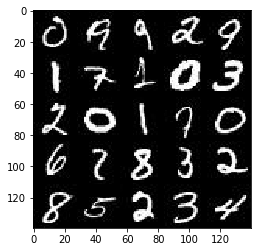

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

In [3]:
print(mnist_images.shape)

(25, 28, 28, 1)


### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

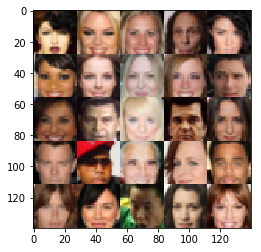

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

In [5]:
mnist_images.shape

(25, 28, 28, 3)

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_images = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels))
    z_data = tf.placeholder(tf.float32, (None, z_dim))
    learning_rate = tf.placeholder(tf.float32)

    return input_images, z_data, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x1 for MNIST and 28x28x3 for CelebA
        x1 = tf.layers.conv2d(images, 64, 3, strides=2, padding='same',
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        # No batch normalization here
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64 now
    
        x2 = tf.layers.conv2d(relu1, 128, 3, strides=2, padding='same',
                             kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128 now

        x3 = tf.layers.conv2d(relu2, 256, 3, strides=2, padding='same',
                             kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)   
        # 4x4x256 now

        flat = tf.reshape(relu3, (-1, 4*4*256))
        # dropout
        flat_drop = tf.nn.dropout(flat, keep_prob=0.9)
        # flat = tf.reshape(relu2, (-1, 7*7*128))
        logits = tf.layers.dense(flat_drop, 1, 
                                 kernel_initializer=tf.contrib.layers.xavier_initializer())
        out = tf.sigmoid(logits)

        return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.1):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse = (not is_train)):        
        # First fully connected layer
        x0 = tf.layers.dense(z, 2*2*1024, kernel_initializer=tf.contrib.layers.xavier_initializer())
        # Reshape it to start the convolutional stack
        x0 = tf.reshape(x0, (-1, 2, 2, 1024))
        x0 = tf.layers.batch_normalization(x0, training=is_train)
        x0 = tf.maximum(alpha * x0, x0)
        # 2x2x1024 now
        
        x1 = tf.layers.conv2d_transpose(x0, 64, 2, strides=2, padding='same',
                                       kernel_initializer=tf.contrib.layers.xavier_initializer())
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        #x1 = tf.nn.dropout(x1, keep_prob=0.5)
        # 4x4x64 now
        
        x2 = tf.layers.conv2d_transpose(x1, 32, 4, strides=1, padding='valid',
                                       kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        #x2 = tf.nn.dropout(x2, keep_prob=0.5)
        # 7x7x32 now
        
        x3 = tf.layers.conv2d_transpose(x2, 16, 4, strides=2, padding='same',
                                       kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # dropout
        #x3 = tf.nn.dropout(x3, keep_prob=0.5)
        # 14x14x16 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same',
                                           kernel_initializer=tf.contrib.layers.xavier_initializer())
        # 28x28xout_channel_dim now
        
        out = tf.tanh(logits) 
                
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    # label smoothing 
    smooth = 0.1
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)* (1 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
      
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Filter variables with names that are in D and G scope names
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    # Tell TensorFlow to update the population statistics while training
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
 
    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    #tf.reset_default_graph()
    
    # Scale of real images
    REAL_SCALE = 0.5 
    
    # Create GAN
    _, im_width, im_height, im_channel = data_shape
    input_real, input_z, l_rate = model_inputs(im_width, im_height, im_channel, z_dim) 
    d_loss, g_loss = model_loss(input_real, input_z, im_channel)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)   
 
    # For printing and showing
    losses = []
    show_every = 100
    print_every = 10
    n_images=25
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            steps = 0
            for batch_images in get_batches(batch_size):
                
                # TODO: Train Model
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers  (run g_opt twice for each d_opt to avoid fast convergence of D)
                _ = sess.run(d_opt, feed_dict={input_real: batch_images/REAL_SCALE, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images/REAL_SCALE})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images/REAL_SCALE})
                
                if steps % print_every == 0:
                    # Get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Bacth {}: Epoch {}/{}...".format(steps, epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, n_images, input_z, im_channel, data_image_mode)
    
    # Not used this time
    return losses

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Bacth 10: Epoch 1/2... Discriminator Loss: 1.2095... Generator Loss: 0.6961
Bacth 20: Epoch 1/2... Discriminator Loss: 1.3632... Generator Loss: 0.5916
Bacth 30: Epoch 1/2... Discriminator Loss: 0.8279... Generator Loss: 1.6199
Bacth 40: Epoch 1/2... Discriminator Loss: 1.5971... Generator Loss: 0.5610
Bacth 50: Epoch 1/2... Discriminator Loss: 2.2172... Generator Loss: 4.1306
Bacth 60: Epoch 1/2... Discriminator Loss: 1.1420... Generator Loss: 3.0349
Bacth 70: Epoch 1/2... Discriminator Loss: 1.1173... Generator Loss: 2.0048
Bacth 80: Epoch 1/2... Discriminator Loss: 1.0229... Generator Loss: 3.2101
Bacth 90: Epoch 1/2... Discriminator Loss: 1.2835... Generator Loss: 2.3118
Bacth 100: Epoch 1/2... Discriminator Loss: 2.1037... Generator Loss: 4.0752


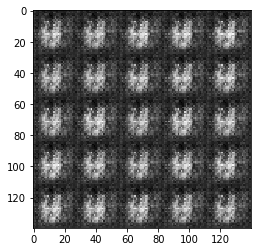

Bacth 110: Epoch 1/2... Discriminator Loss: 1.7032... Generator Loss: 8.0640
Bacth 120: Epoch 1/2... Discriminator Loss: 1.5938... Generator Loss: 3.2009
Bacth 130: Epoch 1/2... Discriminator Loss: 1.9030... Generator Loss: 3.3196
Bacth 140: Epoch 1/2... Discriminator Loss: 1.6258... Generator Loss: 2.2234
Bacth 150: Epoch 1/2... Discriminator Loss: 1.7794... Generator Loss: 3.1735
Bacth 160: Epoch 1/2... Discriminator Loss: 1.9026... Generator Loss: 2.2744
Bacth 170: Epoch 1/2... Discriminator Loss: 2.1220... Generator Loss: 3.3379
Bacth 180: Epoch 1/2... Discriminator Loss: 1.8930... Generator Loss: 0.3676
Bacth 190: Epoch 1/2... Discriminator Loss: 1.2034... Generator Loss: 1.0594
Bacth 200: Epoch 1/2... Discriminator Loss: 3.5841... Generator Loss: 5.4456


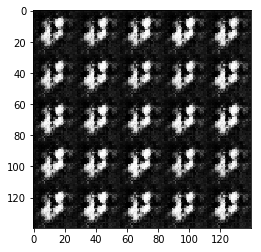

Bacth 210: Epoch 1/2... Discriminator Loss: 1.6690... Generator Loss: 2.1928
Bacth 220: Epoch 1/2... Discriminator Loss: 0.9545... Generator Loss: 2.4554
Bacth 230: Epoch 1/2... Discriminator Loss: 1.0107... Generator Loss: 2.7572
Bacth 240: Epoch 1/2... Discriminator Loss: 2.0383... Generator Loss: 3.5722
Bacth 250: Epoch 1/2... Discriminator Loss: 1.9040... Generator Loss: 1.5218
Bacth 260: Epoch 1/2... Discriminator Loss: 2.0259... Generator Loss: 2.3285
Bacth 270: Epoch 1/2... Discriminator Loss: 2.0385... Generator Loss: 0.9791
Bacth 280: Epoch 1/2... Discriminator Loss: 1.6746... Generator Loss: 0.6708
Bacth 290: Epoch 1/2... Discriminator Loss: 1.8633... Generator Loss: 2.0395
Bacth 300: Epoch 1/2... Discriminator Loss: 2.0608... Generator Loss: 1.2592


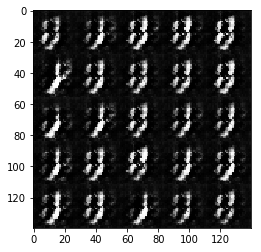

Bacth 310: Epoch 1/2... Discriminator Loss: 3.3520... Generator Loss: 2.5322
Bacth 320: Epoch 1/2... Discriminator Loss: 2.7357... Generator Loss: 3.2941
Bacth 330: Epoch 1/2... Discriminator Loss: 3.2870... Generator Loss: 3.5442
Bacth 340: Epoch 1/2... Discriminator Loss: 2.6882... Generator Loss: 2.1417
Bacth 350: Epoch 1/2... Discriminator Loss: 2.4495... Generator Loss: 2.5644
Bacth 360: Epoch 1/2... Discriminator Loss: 2.1198... Generator Loss: 1.9318
Bacth 370: Epoch 1/2... Discriminator Loss: 4.4325... Generator Loss: 4.0958
Bacth 380: Epoch 1/2... Discriminator Loss: 3.4679... Generator Loss: 3.7226
Bacth 390: Epoch 1/2... Discriminator Loss: 2.3340... Generator Loss: 2.3398
Bacth 400: Epoch 1/2... Discriminator Loss: 2.1605... Generator Loss: 0.6166


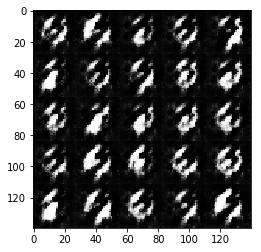

Bacth 410: Epoch 1/2... Discriminator Loss: 2.3233... Generator Loss: 1.7206
Bacth 420: Epoch 1/2... Discriminator Loss: 2.5118... Generator Loss: 1.3475
Bacth 430: Epoch 1/2... Discriminator Loss: 2.4359... Generator Loss: 2.5803
Bacth 440: Epoch 1/2... Discriminator Loss: 3.0794... Generator Loss: 1.6163
Bacth 450: Epoch 1/2... Discriminator Loss: 3.0978... Generator Loss: 1.7038
Bacth 460: Epoch 1/2... Discriminator Loss: 3.8062... Generator Loss: 1.4097
Bacth 470: Epoch 1/2... Discriminator Loss: 3.6098... Generator Loss: 1.0446
Bacth 480: Epoch 1/2... Discriminator Loss: 2.5904... Generator Loss: 0.8383
Bacth 490: Epoch 1/2... Discriminator Loss: 4.2410... Generator Loss: 0.4883
Bacth 500: Epoch 1/2... Discriminator Loss: 3.5096... Generator Loss: 0.7178


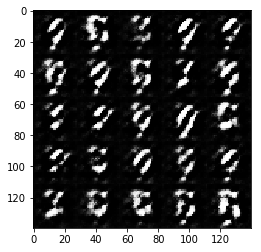

Bacth 510: Epoch 1/2... Discriminator Loss: 3.2053... Generator Loss: 0.4478
Bacth 520: Epoch 1/2... Discriminator Loss: 2.9996... Generator Loss: 2.5312
Bacth 530: Epoch 1/2... Discriminator Loss: 2.8546... Generator Loss: 2.3505
Bacth 540: Epoch 1/2... Discriminator Loss: 3.2245... Generator Loss: 1.5210
Bacth 550: Epoch 1/2... Discriminator Loss: 3.7984... Generator Loss: 0.5989
Bacth 560: Epoch 1/2... Discriminator Loss: 2.6555... Generator Loss: 1.3268
Bacth 570: Epoch 1/2... Discriminator Loss: 2.8002... Generator Loss: 0.6418
Bacth 580: Epoch 1/2... Discriminator Loss: 3.3939... Generator Loss: 1.0175
Bacth 590: Epoch 1/2... Discriminator Loss: 3.7289... Generator Loss: 0.9865
Bacth 600: Epoch 1/2... Discriminator Loss: 3.8194... Generator Loss: 1.7857


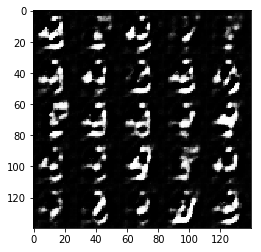

Bacth 610: Epoch 1/2... Discriminator Loss: 3.5790... Generator Loss: 0.9569
Bacth 620: Epoch 1/2... Discriminator Loss: 3.3080... Generator Loss: 1.3922
Bacth 630: Epoch 1/2... Discriminator Loss: 3.2460... Generator Loss: 1.5754
Bacth 640: Epoch 1/2... Discriminator Loss: 3.4356... Generator Loss: 0.9720
Bacth 650: Epoch 1/2... Discriminator Loss: 3.2758... Generator Loss: 0.8186
Bacth 660: Epoch 1/2... Discriminator Loss: 4.1774... Generator Loss: 1.0873
Bacth 670: Epoch 1/2... Discriminator Loss: 4.7494... Generator Loss: 1.9975
Bacth 680: Epoch 1/2... Discriminator Loss: 4.3917... Generator Loss: 0.8663
Bacth 690: Epoch 1/2... Discriminator Loss: 4.8809... Generator Loss: 1.7505
Bacth 700: Epoch 1/2... Discriminator Loss: 4.5361... Generator Loss: 1.5090


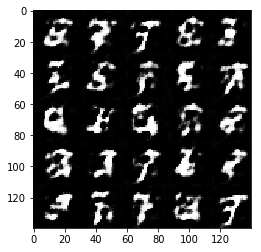

Bacth 710: Epoch 1/2... Discriminator Loss: 4.2343... Generator Loss: 1.5588
Bacth 720: Epoch 1/2... Discriminator Loss: 4.0077... Generator Loss: 0.6023
Bacth 730: Epoch 1/2... Discriminator Loss: 3.4597... Generator Loss: 0.9468
Bacth 740: Epoch 1/2... Discriminator Loss: 4.8846... Generator Loss: 0.6983
Bacth 750: Epoch 1/2... Discriminator Loss: 3.9474... Generator Loss: 1.1745
Bacth 760: Epoch 1/2... Discriminator Loss: 4.5767... Generator Loss: 1.2516
Bacth 770: Epoch 1/2... Discriminator Loss: 3.6478... Generator Loss: 0.3187
Bacth 780: Epoch 1/2... Discriminator Loss: 4.5685... Generator Loss: 1.6758
Bacth 790: Epoch 1/2... Discriminator Loss: 5.7515... Generator Loss: 2.0890
Bacth 800: Epoch 1/2... Discriminator Loss: 4.0856... Generator Loss: 0.9030


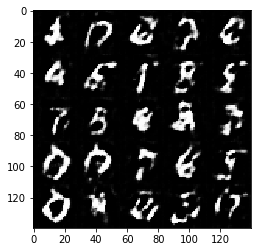

Bacth 810: Epoch 1/2... Discriminator Loss: 4.9557... Generator Loss: 1.3167
Bacth 820: Epoch 1/2... Discriminator Loss: 4.6391... Generator Loss: 1.1570
Bacth 830: Epoch 1/2... Discriminator Loss: 4.8194... Generator Loss: 0.8408
Bacth 840: Epoch 1/2... Discriminator Loss: 4.7626... Generator Loss: 1.3859
Bacth 850: Epoch 1/2... Discriminator Loss: 3.9683... Generator Loss: 0.5050
Bacth 860: Epoch 1/2... Discriminator Loss: 4.3121... Generator Loss: 0.5357
Bacth 870: Epoch 1/2... Discriminator Loss: 4.9337... Generator Loss: 0.7764
Bacth 880: Epoch 1/2... Discriminator Loss: 4.1706... Generator Loss: 0.4047
Bacth 890: Epoch 1/2... Discriminator Loss: 4.7668... Generator Loss: 0.7752
Bacth 900: Epoch 1/2... Discriminator Loss: 3.6488... Generator Loss: 0.4084


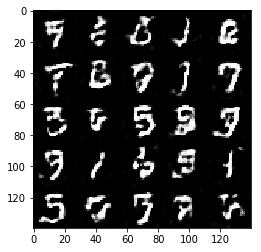

Bacth 910: Epoch 1/2... Discriminator Loss: 4.4190... Generator Loss: 0.9614
Bacth 920: Epoch 1/2... Discriminator Loss: 4.8040... Generator Loss: 0.8472
Bacth 930: Epoch 1/2... Discriminator Loss: 5.7518... Generator Loss: 1.2045
Bacth 940: Epoch 1/2... Discriminator Loss: 4.9117... Generator Loss: 0.7337
Bacth 950: Epoch 1/2... Discriminator Loss: 4.0794... Generator Loss: 0.3928
Bacth 960: Epoch 1/2... Discriminator Loss: 4.4698... Generator Loss: 0.5680
Bacth 970: Epoch 1/2... Discriminator Loss: 4.5288... Generator Loss: 0.9595
Bacth 980: Epoch 1/2... Discriminator Loss: 4.5813... Generator Loss: 1.2089
Bacth 990: Epoch 1/2... Discriminator Loss: 5.2175... Generator Loss: 1.3179
Bacth 1000: Epoch 1/2... Discriminator Loss: 5.3692... Generator Loss: 0.9214


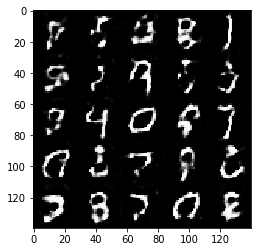

Bacth 1010: Epoch 1/2... Discriminator Loss: 6.0261... Generator Loss: 1.8172
Bacth 1020: Epoch 1/2... Discriminator Loss: 4.5023... Generator Loss: 0.7362
Bacth 1030: Epoch 1/2... Discriminator Loss: 4.5697... Generator Loss: 0.4185
Bacth 1040: Epoch 1/2... Discriminator Loss: 5.1021... Generator Loss: 0.7498
Bacth 1050: Epoch 1/2... Discriminator Loss: 4.9571... Generator Loss: 0.9884
Bacth 1060: Epoch 1/2... Discriminator Loss: 4.9526... Generator Loss: 0.8538
Bacth 1070: Epoch 1/2... Discriminator Loss: 5.6863... Generator Loss: 1.0312
Bacth 1080: Epoch 1/2... Discriminator Loss: 4.7635... Generator Loss: 0.5636
Bacth 1090: Epoch 1/2... Discriminator Loss: 5.8987... Generator Loss: 1.3496
Bacth 1100: Epoch 1/2... Discriminator Loss: 5.0617... Generator Loss: 0.8350


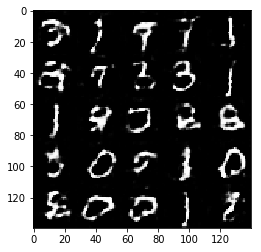

Bacth 1110: Epoch 1/2... Discriminator Loss: 5.7787... Generator Loss: 0.9178
Bacth 1120: Epoch 1/2... Discriminator Loss: 5.9432... Generator Loss: 1.7494
Bacth 1130: Epoch 1/2... Discriminator Loss: 5.3601... Generator Loss: 0.8949
Bacth 1140: Epoch 1/2... Discriminator Loss: 5.0513... Generator Loss: 0.9988
Bacth 1150: Epoch 1/2... Discriminator Loss: 5.7710... Generator Loss: 0.8195
Bacth 1160: Epoch 1/2... Discriminator Loss: 6.3641... Generator Loss: 1.3579
Bacth 1170: Epoch 1/2... Discriminator Loss: 4.8247... Generator Loss: 0.6417
Bacth 1180: Epoch 1/2... Discriminator Loss: 5.1882... Generator Loss: 0.7664
Bacth 1190: Epoch 1/2... Discriminator Loss: 6.2191... Generator Loss: 1.0394
Bacth 1200: Epoch 1/2... Discriminator Loss: 4.9455... Generator Loss: 0.5647


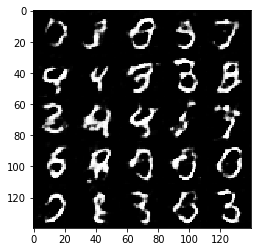

Bacth 1210: Epoch 1/2... Discriminator Loss: 4.2641... Generator Loss: 0.6377
Bacth 1220: Epoch 1/2... Discriminator Loss: 4.4885... Generator Loss: 1.3445
Bacth 1230: Epoch 1/2... Discriminator Loss: 4.7180... Generator Loss: 1.1969
Bacth 1240: Epoch 1/2... Discriminator Loss: 4.4451... Generator Loss: 0.9630
Bacth 1250: Epoch 1/2... Discriminator Loss: 5.6877... Generator Loss: 0.8156
Bacth 1260: Epoch 1/2... Discriminator Loss: 5.1757... Generator Loss: 0.5057
Bacth 1270: Epoch 1/2... Discriminator Loss: 6.1942... Generator Loss: 0.7734
Bacth 1280: Epoch 1/2... Discriminator Loss: 5.4997... Generator Loss: 0.7830
Bacth 1290: Epoch 1/2... Discriminator Loss: 6.1639... Generator Loss: 1.0116
Bacth 1300: Epoch 1/2... Discriminator Loss: 7.3411... Generator Loss: 1.5652


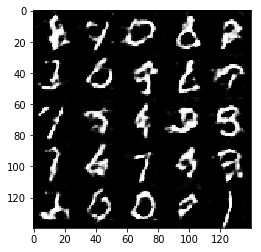

Bacth 1310: Epoch 1/2... Discriminator Loss: 5.5500... Generator Loss: 0.8002
Bacth 1320: Epoch 1/2... Discriminator Loss: 5.7595... Generator Loss: 0.7389
Bacth 1330: Epoch 1/2... Discriminator Loss: 5.1581... Generator Loss: 0.6728
Bacth 1340: Epoch 1/2... Discriminator Loss: 4.2554... Generator Loss: 0.4323
Bacth 1350: Epoch 1/2... Discriminator Loss: 5.3723... Generator Loss: 0.8794
Bacth 1360: Epoch 1/2... Discriminator Loss: 6.4556... Generator Loss: 0.7205
Bacth 1370: Epoch 1/2... Discriminator Loss: 5.5974... Generator Loss: 0.6024
Bacth 1380: Epoch 1/2... Discriminator Loss: 5.8994... Generator Loss: 0.7467
Bacth 1390: Epoch 1/2... Discriminator Loss: 6.2127... Generator Loss: 0.6072
Bacth 1400: Epoch 1/2... Discriminator Loss: 10.0604... Generator Loss: 3.9224


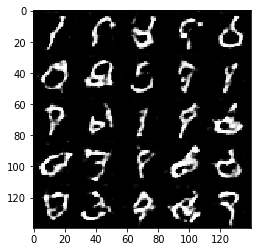

Bacth 1410: Epoch 1/2... Discriminator Loss: 3.3489... Generator Loss: 0.9248
Bacth 1420: Epoch 1/2... Discriminator Loss: 4.2734... Generator Loss: 1.3901
Bacth 1430: Epoch 1/2... Discriminator Loss: 4.6819... Generator Loss: 0.6543
Bacth 1440: Epoch 1/2... Discriminator Loss: 5.1631... Generator Loss: 0.8562
Bacth 1450: Epoch 1/2... Discriminator Loss: 4.7162... Generator Loss: 0.3457
Bacth 1460: Epoch 1/2... Discriminator Loss: 5.9013... Generator Loss: 0.8639
Bacth 1470: Epoch 1/2... Discriminator Loss: 6.2659... Generator Loss: 0.9848
Bacth 1480: Epoch 1/2... Discriminator Loss: 6.4180... Generator Loss: 0.7343
Bacth 1490: Epoch 1/2... Discriminator Loss: 6.0602... Generator Loss: 0.7960
Bacth 1500: Epoch 1/2... Discriminator Loss: 7.2475... Generator Loss: 1.2398


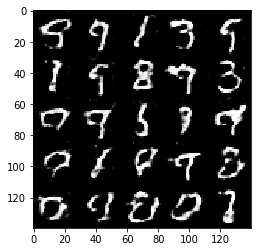

Bacth 1510: Epoch 1/2... Discriminator Loss: 6.1713... Generator Loss: 0.8488
Bacth 1520: Epoch 1/2... Discriminator Loss: 5.9632... Generator Loss: 0.1894
Bacth 1530: Epoch 1/2... Discriminator Loss: 7.0204... Generator Loss: 1.0026
Bacth 1540: Epoch 1/2... Discriminator Loss: 5.7525... Generator Loss: 0.6298
Bacth 1550: Epoch 1/2... Discriminator Loss: 5.8924... Generator Loss: 0.5837
Bacth 1560: Epoch 1/2... Discriminator Loss: 8.4891... Generator Loss: 2.2671
Bacth 1570: Epoch 1/2... Discriminator Loss: 6.7529... Generator Loss: 1.2761
Bacth 1580: Epoch 1/2... Discriminator Loss: 7.1442... Generator Loss: 1.2027
Bacth 1590: Epoch 1/2... Discriminator Loss: 6.3129... Generator Loss: 0.4783
Bacth 1600: Epoch 1/2... Discriminator Loss: 4.0082... Generator Loss: 1.6120


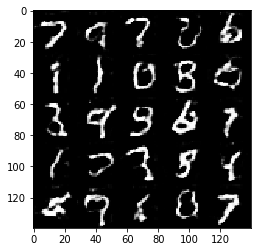

Bacth 1610: Epoch 1/2... Discriminator Loss: 4.1266... Generator Loss: 0.7626
Bacth 1620: Epoch 1/2... Discriminator Loss: 4.5656... Generator Loss: 0.7922
Bacth 1630: Epoch 1/2... Discriminator Loss: 5.4339... Generator Loss: 0.7553
Bacth 1640: Epoch 1/2... Discriminator Loss: 5.8267... Generator Loss: 0.6947
Bacth 1650: Epoch 1/2... Discriminator Loss: 7.1865... Generator Loss: 1.6772
Bacth 1660: Epoch 1/2... Discriminator Loss: 5.5714... Generator Loss: 2.0344
Bacth 1670: Epoch 1/2... Discriminator Loss: 5.5547... Generator Loss: 1.0902
Bacth 1680: Epoch 1/2... Discriminator Loss: 5.2334... Generator Loss: 0.5747
Bacth 1690: Epoch 1/2... Discriminator Loss: 6.7469... Generator Loss: 0.6019
Bacth 1700: Epoch 1/2... Discriminator Loss: 6.2656... Generator Loss: 1.0202


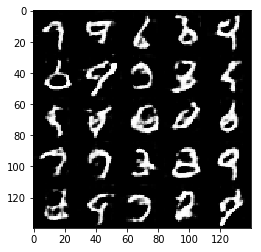

Bacth 1710: Epoch 1/2... Discriminator Loss: 6.4121... Generator Loss: 1.0461
Bacth 1720: Epoch 1/2... Discriminator Loss: 7.2116... Generator Loss: 0.6970
Bacth 1730: Epoch 1/2... Discriminator Loss: 7.8094... Generator Loss: 1.1261
Bacth 1740: Epoch 1/2... Discriminator Loss: 6.4627... Generator Loss: 2.2858
Bacth 1750: Epoch 1/2... Discriminator Loss: 5.3415... Generator Loss: 0.6336
Bacth 1760: Epoch 1/2... Discriminator Loss: 5.1384... Generator Loss: 0.5734
Bacth 1770: Epoch 1/2... Discriminator Loss: 6.4234... Generator Loss: 0.9866
Bacth 1780: Epoch 1/2... Discriminator Loss: 6.1993... Generator Loss: 0.3810
Bacth 1790: Epoch 1/2... Discriminator Loss: 7.0341... Generator Loss: 0.9500
Bacth 1800: Epoch 1/2... Discriminator Loss: 8.9842... Generator Loss: 1.4768


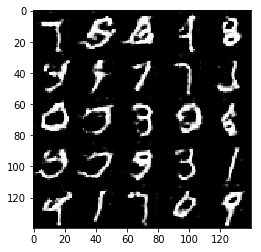

Bacth 1810: Epoch 1/2... Discriminator Loss: 6.8565... Generator Loss: 0.8563
Bacth 1820: Epoch 1/2... Discriminator Loss: 6.9853... Generator Loss: 0.5025
Bacth 1830: Epoch 1/2... Discriminator Loss: 6.5802... Generator Loss: 1.2148
Bacth 1840: Epoch 1/2... Discriminator Loss: 7.0361... Generator Loss: 0.5281
Bacth 1850: Epoch 1/2... Discriminator Loss: 6.8848... Generator Loss: 0.6151
Bacth 1860: Epoch 1/2... Discriminator Loss: 6.5648... Generator Loss: 0.6238
Bacth 1870: Epoch 1/2... Discriminator Loss: 8.5468... Generator Loss: 1.8926
Bacth 10: Epoch 2/2... Discriminator Loss: 7.1052... Generator Loss: 0.5115
Bacth 20: Epoch 2/2... Discriminator Loss: 7.9020... Generator Loss: 1.2543
Bacth 30: Epoch 2/2... Discriminator Loss: 7.7691... Generator Loss: 0.8557
Bacth 40: Epoch 2/2... Discriminator Loss: 9.0788... Generator Loss: 1.5457
Bacth 50: Epoch 2/2... Discriminator Loss: 9.2933... Generator Loss: 1.9455
Bacth 60: Epoch 2/2... Discriminator Loss: 7.5351... Generator Loss: 0.647

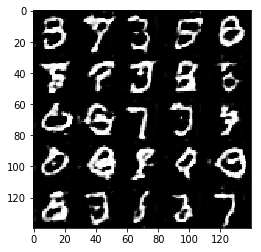

Bacth 110: Epoch 2/2... Discriminator Loss: 6.0236... Generator Loss: 0.6981
Bacth 120: Epoch 2/2... Discriminator Loss: 6.7350... Generator Loss: 0.6726
Bacth 130: Epoch 2/2... Discriminator Loss: 6.7284... Generator Loss: 0.4830
Bacth 140: Epoch 2/2... Discriminator Loss: 8.0534... Generator Loss: 0.7604
Bacth 150: Epoch 2/2... Discriminator Loss: 7.4795... Generator Loss: 0.6249
Bacth 160: Epoch 2/2... Discriminator Loss: 7.8010... Generator Loss: 1.0540
Bacth 170: Epoch 2/2... Discriminator Loss: 7.6625... Generator Loss: 0.9102
Bacth 180: Epoch 2/2... Discriminator Loss: 7.8689... Generator Loss: 1.0370
Bacth 190: Epoch 2/2... Discriminator Loss: 8.0328... Generator Loss: 0.4965
Bacth 200: Epoch 2/2... Discriminator Loss: 6.1897... Generator Loss: 0.8204


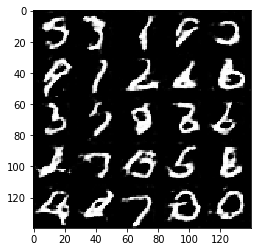

Bacth 210: Epoch 2/2... Discriminator Loss: 6.2021... Generator Loss: 0.8419
Bacth 220: Epoch 2/2... Discriminator Loss: 7.1445... Generator Loss: 1.1084
Bacth 230: Epoch 2/2... Discriminator Loss: 7.7496... Generator Loss: 0.4567
Bacth 240: Epoch 2/2... Discriminator Loss: 6.7828... Generator Loss: 1.2572
Bacth 250: Epoch 2/2... Discriminator Loss: 7.7027... Generator Loss: 0.9522
Bacth 260: Epoch 2/2... Discriminator Loss: 7.8651... Generator Loss: 1.2852
Bacth 270: Epoch 2/2... Discriminator Loss: 8.0899... Generator Loss: 0.8448
Bacth 280: Epoch 2/2... Discriminator Loss: 8.8655... Generator Loss: 1.5225
Bacth 290: Epoch 2/2... Discriminator Loss: 8.0517... Generator Loss: 0.5101
Bacth 300: Epoch 2/2... Discriminator Loss: 8.1728... Generator Loss: 0.9697


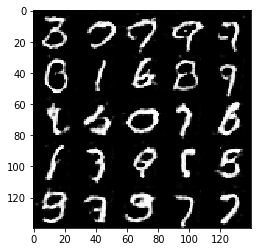

Bacth 310: Epoch 2/2... Discriminator Loss: 8.8585... Generator Loss: 1.2001
Bacth 320: Epoch 2/2... Discriminator Loss: 8.2045... Generator Loss: 1.1773
Bacth 330: Epoch 2/2... Discriminator Loss: 10.2874... Generator Loss: 2.0035
Bacth 340: Epoch 2/2... Discriminator Loss: 8.3928... Generator Loss: 0.7612
Bacth 350: Epoch 2/2... Discriminator Loss: 9.0226... Generator Loss: 0.7883
Bacth 360: Epoch 2/2... Discriminator Loss: 7.1922... Generator Loss: 0.3533
Bacth 370: Epoch 2/2... Discriminator Loss: 7.2302... Generator Loss: 0.6943
Bacth 380: Epoch 2/2... Discriminator Loss: 8.4752... Generator Loss: 1.0300
Bacth 390: Epoch 2/2... Discriminator Loss: 9.1136... Generator Loss: 1.1106
Bacth 400: Epoch 2/2... Discriminator Loss: 6.6259... Generator Loss: 1.1022


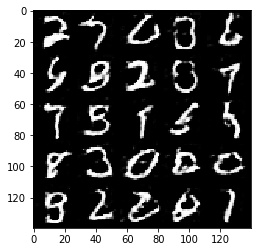

Bacth 410: Epoch 2/2... Discriminator Loss: 8.6373... Generator Loss: 1.0995
Bacth 420: Epoch 2/2... Discriminator Loss: 7.6323... Generator Loss: 1.3873
Bacth 430: Epoch 2/2... Discriminator Loss: 8.2086... Generator Loss: 0.6715
Bacth 440: Epoch 2/2... Discriminator Loss: 9.6675... Generator Loss: 1.0542
Bacth 450: Epoch 2/2... Discriminator Loss: 8.4614... Generator Loss: 0.6156
Bacth 460: Epoch 2/2... Discriminator Loss: 8.7304... Generator Loss: 0.6234
Bacth 470: Epoch 2/2... Discriminator Loss: 8.3410... Generator Loss: 1.2300
Bacth 480: Epoch 2/2... Discriminator Loss: 9.1000... Generator Loss: 1.0571
Bacth 490: Epoch 2/2... Discriminator Loss: 9.3898... Generator Loss: 1.1625
Bacth 500: Epoch 2/2... Discriminator Loss: 7.9513... Generator Loss: 1.6046


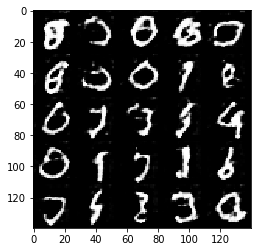

Bacth 510: Epoch 2/2... Discriminator Loss: 9.1934... Generator Loss: 0.8667
Bacth 520: Epoch 2/2... Discriminator Loss: 9.1339... Generator Loss: 0.8174
Bacth 530: Epoch 2/2... Discriminator Loss: 6.4776... Generator Loss: 0.0034
Bacth 540: Epoch 2/2... Discriminator Loss: 3.5883... Generator Loss: 0.8288
Bacth 550: Epoch 2/2... Discriminator Loss: 4.2537... Generator Loss: 1.5745
Bacth 560: Epoch 2/2... Discriminator Loss: 4.6071... Generator Loss: 1.4475
Bacth 570: Epoch 2/2... Discriminator Loss: 5.3103... Generator Loss: 1.2490
Bacth 580: Epoch 2/2... Discriminator Loss: 5.5663... Generator Loss: 0.7617
Bacth 590: Epoch 2/2... Discriminator Loss: 5.8511... Generator Loss: 1.5276
Bacth 600: Epoch 2/2... Discriminator Loss: 6.2462... Generator Loss: 0.7835


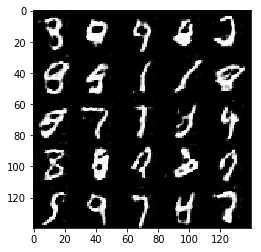

Bacth 610: Epoch 2/2... Discriminator Loss: 6.9989... Generator Loss: 1.3289
Bacth 620: Epoch 2/2... Discriminator Loss: 7.7851... Generator Loss: 1.4536
Bacth 630: Epoch 2/2... Discriminator Loss: 8.2490... Generator Loss: 1.5701
Bacth 640: Epoch 2/2... Discriminator Loss: 8.6778... Generator Loss: 1.6996
Bacth 650: Epoch 2/2... Discriminator Loss: 7.2265... Generator Loss: 1.1752
Bacth 660: Epoch 2/2... Discriminator Loss: 7.7477... Generator Loss: 1.2615
Bacth 670: Epoch 2/2... Discriminator Loss: 8.4039... Generator Loss: 1.2232
Bacth 680: Epoch 2/2... Discriminator Loss: 9.2202... Generator Loss: 0.8849
Bacth 690: Epoch 2/2... Discriminator Loss: 8.5264... Generator Loss: 1.1196
Bacth 700: Epoch 2/2... Discriminator Loss: 8.7704... Generator Loss: 0.9413


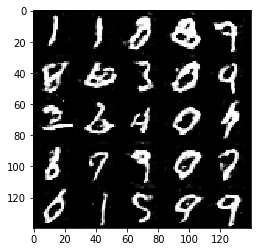

Bacth 710: Epoch 2/2... Discriminator Loss: 8.8421... Generator Loss: 0.8672
Bacth 720: Epoch 2/2... Discriminator Loss: 9.1852... Generator Loss: 1.2783
Bacth 730: Epoch 2/2... Discriminator Loss: 8.9139... Generator Loss: 0.6764
Bacth 740: Epoch 2/2... Discriminator Loss: 9.0702... Generator Loss: 1.8894
Bacth 750: Epoch 2/2... Discriminator Loss: 11.4425... Generator Loss: 3.1279
Bacth 760: Epoch 2/2... Discriminator Loss: 6.7108... Generator Loss: 1.1424
Bacth 770: Epoch 2/2... Discriminator Loss: 7.4730... Generator Loss: 1.1100
Bacth 780: Epoch 2/2... Discriminator Loss: 8.2509... Generator Loss: 1.3427
Bacth 790: Epoch 2/2... Discriminator Loss: 8.6338... Generator Loss: 1.3759
Bacth 800: Epoch 2/2... Discriminator Loss: 9.9533... Generator Loss: 1.6825


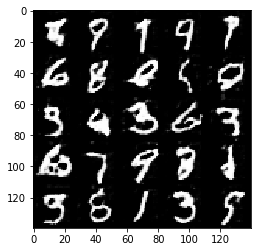

Bacth 810: Epoch 2/2... Discriminator Loss: 8.3129... Generator Loss: 0.7345
Bacth 820: Epoch 2/2... Discriminator Loss: 9.5600... Generator Loss: 1.4105
Bacth 830: Epoch 2/2... Discriminator Loss: 10.2134... Generator Loss: 1.0975
Bacth 840: Epoch 2/2... Discriminator Loss: 9.8836... Generator Loss: 1.6713
Bacth 850: Epoch 2/2... Discriminator Loss: 9.9846... Generator Loss: 0.9530
Bacth 860: Epoch 2/2... Discriminator Loss: 9.7947... Generator Loss: 0.8012
Bacth 870: Epoch 2/2... Discriminator Loss: 10.8343... Generator Loss: 2.4782
Bacth 880: Epoch 2/2... Discriminator Loss: 9.2979... Generator Loss: 0.7129
Bacth 890: Epoch 2/2... Discriminator Loss: 9.5306... Generator Loss: 0.7987
Bacth 900: Epoch 2/2... Discriminator Loss: 9.9003... Generator Loss: 0.6990


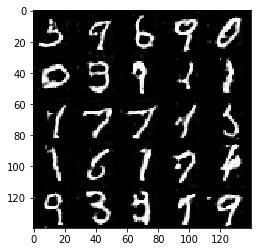

Bacth 910: Epoch 2/2... Discriminator Loss: 9.5269... Generator Loss: 0.4634
Bacth 920: Epoch 2/2... Discriminator Loss: 5.2063... Generator Loss: 0.6264
Bacth 930: Epoch 2/2... Discriminator Loss: 4.2338... Generator Loss: 1.0184
Bacth 940: Epoch 2/2... Discriminator Loss: 5.9226... Generator Loss: 0.6842
Bacth 950: Epoch 2/2... Discriminator Loss: 6.2547... Generator Loss: 1.2777
Bacth 960: Epoch 2/2... Discriminator Loss: 7.1467... Generator Loss: 1.5111
Bacth 970: Epoch 2/2... Discriminator Loss: 7.9733... Generator Loss: 1.7814
Bacth 980: Epoch 2/2... Discriminator Loss: 7.5696... Generator Loss: 1.7515
Bacth 990: Epoch 2/2... Discriminator Loss: 7.3414... Generator Loss: 1.3071
Bacth 1000: Epoch 2/2... Discriminator Loss: 7.6752... Generator Loss: 1.4107


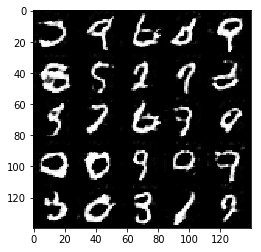

Bacth 1010: Epoch 2/2... Discriminator Loss: 8.3643... Generator Loss: 1.1218
Bacth 1020: Epoch 2/2... Discriminator Loss: 8.4148... Generator Loss: 1.2152
Bacth 1030: Epoch 2/2... Discriminator Loss: 8.2538... Generator Loss: 0.6831
Bacth 1040: Epoch 2/2... Discriminator Loss: 8.7372... Generator Loss: 0.9994
Bacth 1050: Epoch 2/2... Discriminator Loss: 8.8382... Generator Loss: 1.1077
Bacth 1060: Epoch 2/2... Discriminator Loss: 8.8204... Generator Loss: 1.0293
Bacth 1070: Epoch 2/2... Discriminator Loss: 9.4733... Generator Loss: 1.2353
Bacth 1080: Epoch 2/2... Discriminator Loss: 8.9948... Generator Loss: 0.8017
Bacth 1090: Epoch 2/2... Discriminator Loss: 10.7618... Generator Loss: 1.9604
Bacth 1100: Epoch 2/2... Discriminator Loss: 3.7809... Generator Loss: 0.5705


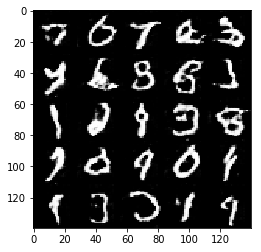

Bacth 1110: Epoch 2/2... Discriminator Loss: 4.2826... Generator Loss: 1.6080
Bacth 1120: Epoch 2/2... Discriminator Loss: 4.9239... Generator Loss: 1.7304
Bacth 1130: Epoch 2/2... Discriminator Loss: 5.4429... Generator Loss: 1.2583
Bacth 1140: Epoch 2/2... Discriminator Loss: 5.5784... Generator Loss: 1.2397
Bacth 1150: Epoch 2/2... Discriminator Loss: 5.6568... Generator Loss: 1.3141
Bacth 1160: Epoch 2/2... Discriminator Loss: 6.8677... Generator Loss: 1.0483
Bacth 1170: Epoch 2/2... Discriminator Loss: 7.1168... Generator Loss: 0.5366
Bacth 1180: Epoch 2/2... Discriminator Loss: 6.9920... Generator Loss: 1.1593
Bacth 1190: Epoch 2/2... Discriminator Loss: 7.3529... Generator Loss: 1.1554
Bacth 1200: Epoch 2/2... Discriminator Loss: 7.8823... Generator Loss: 0.9491


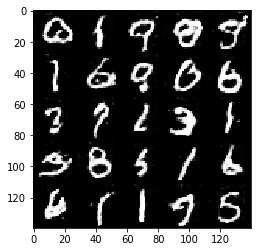

Bacth 1210: Epoch 2/2... Discriminator Loss: 8.4066... Generator Loss: 2.0492
Bacth 1220: Epoch 2/2... Discriminator Loss: 8.2459... Generator Loss: 0.8868
Bacth 1230: Epoch 2/2... Discriminator Loss: 9.0478... Generator Loss: 1.3784
Bacth 1240: Epoch 2/2... Discriminator Loss: 8.1625... Generator Loss: 0.9613
Bacth 1250: Epoch 2/2... Discriminator Loss: 8.6828... Generator Loss: 1.1950
Bacth 1260: Epoch 2/2... Discriminator Loss: 7.9601... Generator Loss: 1.0077
Bacth 1270: Epoch 2/2... Discriminator Loss: 8.7379... Generator Loss: 1.7135
Bacth 1280: Epoch 2/2... Discriminator Loss: 9.3766... Generator Loss: 2.0755
Bacth 1290: Epoch 2/2... Discriminator Loss: 8.0576... Generator Loss: 1.4150
Bacth 1300: Epoch 2/2... Discriminator Loss: 9.1888... Generator Loss: 1.4485


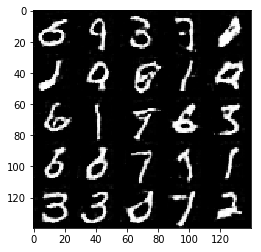

Bacth 1310: Epoch 2/2... Discriminator Loss: 8.2142... Generator Loss: 1.2553
Bacth 1320: Epoch 2/2... Discriminator Loss: 8.9569... Generator Loss: 1.2506
Bacth 1330: Epoch 2/2... Discriminator Loss: 9.2760... Generator Loss: 1.4487
Bacth 1340: Epoch 2/2... Discriminator Loss: 8.7120... Generator Loss: 1.2862
Bacth 1350: Epoch 2/2... Discriminator Loss: 8.0101... Generator Loss: 0.6801
Bacth 1360: Epoch 2/2... Discriminator Loss: 8.5597... Generator Loss: 1.5482
Bacth 1370: Epoch 2/2... Discriminator Loss: 8.4751... Generator Loss: 1.2202
Bacth 1380: Epoch 2/2... Discriminator Loss: 9.2093... Generator Loss: 0.7704
Bacth 1390: Epoch 2/2... Discriminator Loss: 9.0349... Generator Loss: 1.1273
Bacth 1400: Epoch 2/2... Discriminator Loss: 8.1231... Generator Loss: 1.0834


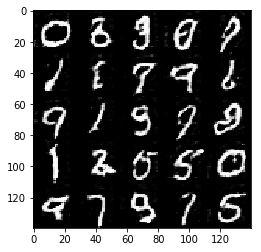

Bacth 1410: Epoch 2/2... Discriminator Loss: 9.8200... Generator Loss: 1.4830
Bacth 1420: Epoch 2/2... Discriminator Loss: 9.9884... Generator Loss: 1.0863
Bacth 1430: Epoch 2/2... Discriminator Loss: 10.2567... Generator Loss: 1.2356
Bacth 1440: Epoch 2/2... Discriminator Loss: 8.8434... Generator Loss: 1.1318
Bacth 1450: Epoch 2/2... Discriminator Loss: 8.9200... Generator Loss: 1.3721
Bacth 1460: Epoch 2/2... Discriminator Loss: 9.0472... Generator Loss: 1.2482
Bacth 1470: Epoch 2/2... Discriminator Loss: 12.9680... Generator Loss: 7.1746
Bacth 1480: Epoch 2/2... Discriminator Loss: 4.0009... Generator Loss: 2.0719
Bacth 1490: Epoch 2/2... Discriminator Loss: 4.1823... Generator Loss: 1.2109
Bacth 1500: Epoch 2/2... Discriminator Loss: 4.5974... Generator Loss: 0.7798


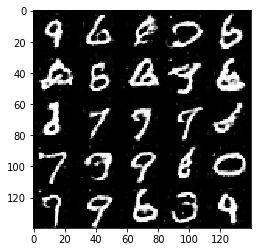

Bacth 1510: Epoch 2/2... Discriminator Loss: 5.6870... Generator Loss: 1.2213
Bacth 1520: Epoch 2/2... Discriminator Loss: 6.2281... Generator Loss: 1.1851
Bacth 1530: Epoch 2/2... Discriminator Loss: 6.7144... Generator Loss: 1.4807
Bacth 1540: Epoch 2/2... Discriminator Loss: 7.0315... Generator Loss: 0.7932
Bacth 1550: Epoch 2/2... Discriminator Loss: 6.5790... Generator Loss: 1.1276
Bacth 1560: Epoch 2/2... Discriminator Loss: 7.8188... Generator Loss: 1.7118
Bacth 1570: Epoch 2/2... Discriminator Loss: 7.1274... Generator Loss: 1.1560
Bacth 1580: Epoch 2/2... Discriminator Loss: 8.2256... Generator Loss: 1.9088
Bacth 1590: Epoch 2/2... Discriminator Loss: 8.5537... Generator Loss: 2.6268
Bacth 1600: Epoch 2/2... Discriminator Loss: 6.9773... Generator Loss: 0.9746


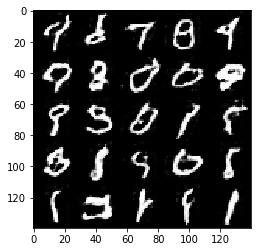

Bacth 1610: Epoch 2/2... Discriminator Loss: 6.9729... Generator Loss: 0.5892
Bacth 1620: Epoch 2/2... Discriminator Loss: 7.5844... Generator Loss: 1.4586
Bacth 1630: Epoch 2/2... Discriminator Loss: 7.7276... Generator Loss: 0.9825
Bacth 1640: Epoch 2/2... Discriminator Loss: 7.8307... Generator Loss: 0.7755
Bacth 1650: Epoch 2/2... Discriminator Loss: 8.8218... Generator Loss: 1.4666
Bacth 1660: Epoch 2/2... Discriminator Loss: 8.2309... Generator Loss: 1.0772
Bacth 1670: Epoch 2/2... Discriminator Loss: 8.6767... Generator Loss: 1.2094
Bacth 1680: Epoch 2/2... Discriminator Loss: 9.4082... Generator Loss: 1.5433
Bacth 1690: Epoch 2/2... Discriminator Loss: 9.0405... Generator Loss: 0.6804
Bacth 1700: Epoch 2/2... Discriminator Loss: 8.7768... Generator Loss: 0.9575


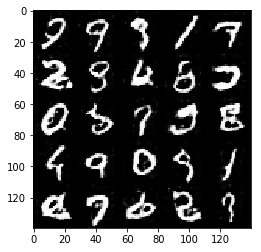

Bacth 1710: Epoch 2/2... Discriminator Loss: 9.7175... Generator Loss: 1.6862
Bacth 1720: Epoch 2/2... Discriminator Loss: 5.8769... Generator Loss: 1.4610
Bacth 1730: Epoch 2/2... Discriminator Loss: 5.0383... Generator Loss: 1.7668
Bacth 1740: Epoch 2/2... Discriminator Loss: 7.1558... Generator Loss: 1.8402
Bacth 1750: Epoch 2/2... Discriminator Loss: 6.9490... Generator Loss: 1.8974
Bacth 1760: Epoch 2/2... Discriminator Loss: 7.2552... Generator Loss: 0.8289
Bacth 1770: Epoch 2/2... Discriminator Loss: 8.1716... Generator Loss: 0.8669
Bacth 1780: Epoch 2/2... Discriminator Loss: 8.0019... Generator Loss: 1.1398
Bacth 1790: Epoch 2/2... Discriminator Loss: 8.2413... Generator Loss: 0.8728
Bacth 1800: Epoch 2/2... Discriminator Loss: 8.2833... Generator Loss: 0.6430


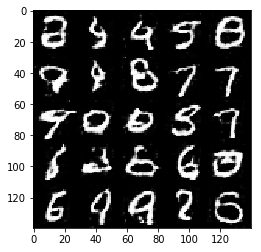

Bacth 1810: Epoch 2/2... Discriminator Loss: 8.7595... Generator Loss: 0.9475
Bacth 1820: Epoch 2/2... Discriminator Loss: 8.7774... Generator Loss: 0.7845
Bacth 1830: Epoch 2/2... Discriminator Loss: 8.8355... Generator Loss: 0.7503
Bacth 1840: Epoch 2/2... Discriminator Loss: 9.4637... Generator Loss: 0.7653
Bacth 1850: Epoch 2/2... Discriminator Loss: 9.1173... Generator Loss: 1.2430
Bacth 1860: Epoch 2/2... Discriminator Loss: 8.9821... Generator Loss: 1.3927
Bacth 1870: Epoch 2/2... Discriminator Loss: 11.1185... Generator Loss: 3.5894


In [12]:
batch_size = 32
z_dim = 100
learning_rate = 0.0003
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Bacth 10: Epoch 1/1... Discriminator Loss: 1.3280... Generator Loss: 0.6158
Bacth 20: Epoch 1/1... Discriminator Loss: 0.8234... Generator Loss: 1.0749
Bacth 30: Epoch 1/1... Discriminator Loss: 0.4974... Generator Loss: 2.4266
Bacth 40: Epoch 1/1... Discriminator Loss: 0.4755... Generator Loss: 2.5877
Bacth 50: Epoch 1/1... Discriminator Loss: 0.4486... Generator Loss: 3.0174
Bacth 60: Epoch 1/1... Discriminator Loss: 0.3887... Generator Loss: 6.2699
Bacth 70: Epoch 1/1... Discriminator Loss: 0.3998... Generator Loss: 3.9688
Bacth 80: Epoch 1/1... Discriminator Loss: 0.5923... Generator Loss: 1.7597
Bacth 90: Epoch 1/1... Discriminator Loss: 0.4661... Generator Loss: 4.4977
Bacth 100: Epoch 1/1... Discriminator Loss: 0.4827... Generator Loss: 2.9184


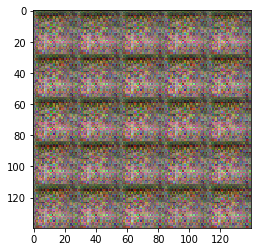

Bacth 110: Epoch 1/1... Discriminator Loss: 0.5867... Generator Loss: 2.1239
Bacth 120: Epoch 1/1... Discriminator Loss: 0.5191... Generator Loss: 2.7385
Bacth 130: Epoch 1/1... Discriminator Loss: 0.7057... Generator Loss: 1.6850
Bacth 140: Epoch 1/1... Discriminator Loss: 0.6024... Generator Loss: 4.4449
Bacth 150: Epoch 1/1... Discriminator Loss: 0.6942... Generator Loss: 2.4020
Bacth 160: Epoch 1/1... Discriminator Loss: 0.4829... Generator Loss: 3.9440
Bacth 170: Epoch 1/1... Discriminator Loss: 0.9321... Generator Loss: 0.9958
Bacth 180: Epoch 1/1... Discriminator Loss: 0.4923... Generator Loss: 3.7742
Bacth 190: Epoch 1/1... Discriminator Loss: 0.6112... Generator Loss: 2.6253
Bacth 200: Epoch 1/1... Discriminator Loss: 0.7587... Generator Loss: 1.5120


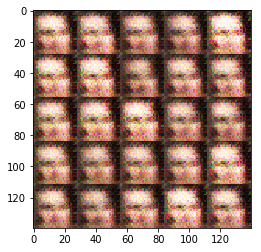

Bacth 210: Epoch 1/1... Discriminator Loss: 1.4550... Generator Loss: 0.4900
Bacth 220: Epoch 1/1... Discriminator Loss: 0.8154... Generator Loss: 1.8781
Bacth 230: Epoch 1/1... Discriminator Loss: 0.9243... Generator Loss: 1.9492
Bacth 240: Epoch 1/1... Discriminator Loss: 1.0871... Generator Loss: 1.8525
Bacth 250: Epoch 1/1... Discriminator Loss: 1.0074... Generator Loss: 1.2215
Bacth 260: Epoch 1/1... Discriminator Loss: 0.9753... Generator Loss: 2.1793
Bacth 270: Epoch 1/1... Discriminator Loss: 1.3682... Generator Loss: 3.3089
Bacth 280: Epoch 1/1... Discriminator Loss: 0.9377... Generator Loss: 1.6131
Bacth 290: Epoch 1/1... Discriminator Loss: 0.8017... Generator Loss: 2.1754
Bacth 300: Epoch 1/1... Discriminator Loss: 0.8555... Generator Loss: 1.3153


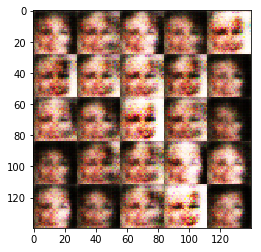

Bacth 310: Epoch 1/1... Discriminator Loss: 1.5374... Generator Loss: 5.1666
Bacth 320: Epoch 1/1... Discriminator Loss: 0.6206... Generator Loss: 2.0505
Bacth 330: Epoch 1/1... Discriminator Loss: 0.9162... Generator Loss: 2.5987
Bacth 340: Epoch 1/1... Discriminator Loss: 0.9359... Generator Loss: 1.3509
Bacth 350: Epoch 1/1... Discriminator Loss: 0.9098... Generator Loss: 1.4578
Bacth 360: Epoch 1/1... Discriminator Loss: 0.7743... Generator Loss: 1.7379
Bacth 370: Epoch 1/1... Discriminator Loss: 1.2853... Generator Loss: 0.7997
Bacth 380: Epoch 1/1... Discriminator Loss: 0.6685... Generator Loss: 1.8973
Bacth 390: Epoch 1/1... Discriminator Loss: 0.5070... Generator Loss: 3.7537
Bacth 400: Epoch 1/1... Discriminator Loss: 0.7250... Generator Loss: 1.7678


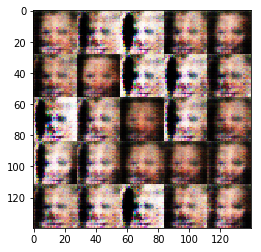

Bacth 410: Epoch 1/1... Discriminator Loss: 0.6700... Generator Loss: 1.8118
Bacth 420: Epoch 1/1... Discriminator Loss: 0.8321... Generator Loss: 1.7182
Bacth 430: Epoch 1/1... Discriminator Loss: 0.9085... Generator Loss: 1.4344
Bacth 440: Epoch 1/1... Discriminator Loss: 1.3282... Generator Loss: 0.9541
Bacth 450: Epoch 1/1... Discriminator Loss: 1.5052... Generator Loss: 0.5334
Bacth 460: Epoch 1/1... Discriminator Loss: 0.8494... Generator Loss: 1.6300
Bacth 470: Epoch 1/1... Discriminator Loss: 0.5806... Generator Loss: 2.1544
Bacth 480: Epoch 1/1... Discriminator Loss: 0.7085... Generator Loss: 1.8975
Bacth 490: Epoch 1/1... Discriminator Loss: 1.0024... Generator Loss: 0.8127
Bacth 500: Epoch 1/1... Discriminator Loss: 0.6668... Generator Loss: 1.9583


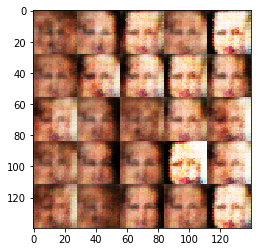

Bacth 510: Epoch 1/1... Discriminator Loss: 1.1688... Generator Loss: 0.8156
Bacth 520: Epoch 1/1... Discriminator Loss: 0.6425... Generator Loss: 2.0110
Bacth 530: Epoch 1/1... Discriminator Loss: 0.9031... Generator Loss: 3.4323
Bacth 540: Epoch 1/1... Discriminator Loss: 0.6416... Generator Loss: 2.2666
Bacth 550: Epoch 1/1... Discriminator Loss: 1.5084... Generator Loss: 0.6891
Bacth 560: Epoch 1/1... Discriminator Loss: 0.6761... Generator Loss: 1.6115
Bacth 570: Epoch 1/1... Discriminator Loss: 1.0700... Generator Loss: 1.0468
Bacth 580: Epoch 1/1... Discriminator Loss: 1.2915... Generator Loss: 0.9165
Bacth 590: Epoch 1/1... Discriminator Loss: 1.2457... Generator Loss: 0.8676
Bacth 600: Epoch 1/1... Discriminator Loss: 0.8333... Generator Loss: 1.9700


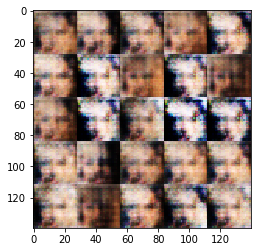

Bacth 610: Epoch 1/1... Discriminator Loss: 0.8790... Generator Loss: 1.5918
Bacth 620: Epoch 1/1... Discriminator Loss: 1.4217... Generator Loss: 0.5844
Bacth 630: Epoch 1/1... Discriminator Loss: 0.8025... Generator Loss: 1.4904
Bacth 640: Epoch 1/1... Discriminator Loss: 0.7235... Generator Loss: 1.6428
Bacth 650: Epoch 1/1... Discriminator Loss: 0.6579... Generator Loss: 2.2949
Bacth 660: Epoch 1/1... Discriminator Loss: 1.1086... Generator Loss: 1.1310
Bacth 670: Epoch 1/1... Discriminator Loss: 1.4913... Generator Loss: 0.5505
Bacth 680: Epoch 1/1... Discriminator Loss: 0.9174... Generator Loss: 0.9972
Bacth 690: Epoch 1/1... Discriminator Loss: 0.8979... Generator Loss: 1.7266
Bacth 700: Epoch 1/1... Discriminator Loss: 0.9110... Generator Loss: 1.1350


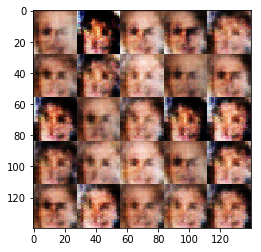

Bacth 710: Epoch 1/1... Discriminator Loss: 0.9627... Generator Loss: 1.2427
Bacth 720: Epoch 1/1... Discriminator Loss: 0.8026... Generator Loss: 1.5717
Bacth 730: Epoch 1/1... Discriminator Loss: 1.3603... Generator Loss: 1.2992
Bacth 740: Epoch 1/1... Discriminator Loss: 1.2172... Generator Loss: 1.1514
Bacth 750: Epoch 1/1... Discriminator Loss: 0.9827... Generator Loss: 2.9940
Bacth 760: Epoch 1/1... Discriminator Loss: 1.2813... Generator Loss: 0.8416
Bacth 770: Epoch 1/1... Discriminator Loss: 1.3514... Generator Loss: 0.6623
Bacth 780: Epoch 1/1... Discriminator Loss: 1.0035... Generator Loss: 0.9209
Bacth 790: Epoch 1/1... Discriminator Loss: 1.2068... Generator Loss: 0.8386
Bacth 800: Epoch 1/1... Discriminator Loss: 0.9589... Generator Loss: 1.1709


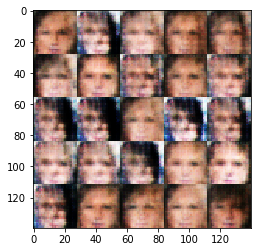

Bacth 810: Epoch 1/1... Discriminator Loss: 1.0801... Generator Loss: 0.8252
Bacth 820: Epoch 1/1... Discriminator Loss: 0.7923... Generator Loss: 2.3849
Bacth 830: Epoch 1/1... Discriminator Loss: 1.0863... Generator Loss: 1.1403
Bacth 840: Epoch 1/1... Discriminator Loss: 1.6031... Generator Loss: 0.4561
Bacth 850: Epoch 1/1... Discriminator Loss: 1.2427... Generator Loss: 2.4669
Bacth 860: Epoch 1/1... Discriminator Loss: 1.5544... Generator Loss: 0.6822
Bacth 870: Epoch 1/1... Discriminator Loss: 1.1380... Generator Loss: 2.0487
Bacth 880: Epoch 1/1... Discriminator Loss: 1.1813... Generator Loss: 1.6649
Bacth 890: Epoch 1/1... Discriminator Loss: 1.2780... Generator Loss: 0.7668
Bacth 900: Epoch 1/1... Discriminator Loss: 1.1855... Generator Loss: 1.1455


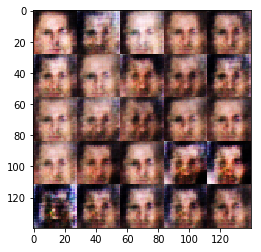

Bacth 910: Epoch 1/1... Discriminator Loss: 1.3196... Generator Loss: 1.2682
Bacth 920: Epoch 1/1... Discriminator Loss: 1.0899... Generator Loss: 1.6543
Bacth 930: Epoch 1/1... Discriminator Loss: 1.2355... Generator Loss: 1.1360
Bacth 940: Epoch 1/1... Discriminator Loss: 1.5593... Generator Loss: 0.5649
Bacth 950: Epoch 1/1... Discriminator Loss: 0.9937... Generator Loss: 1.3687
Bacth 960: Epoch 1/1... Discriminator Loss: 1.0387... Generator Loss: 1.5538
Bacth 970: Epoch 1/1... Discriminator Loss: 0.9561... Generator Loss: 2.1111
Bacth 980: Epoch 1/1... Discriminator Loss: 1.2503... Generator Loss: 1.5975
Bacth 990: Epoch 1/1... Discriminator Loss: 1.4958... Generator Loss: 0.9350
Bacth 1000: Epoch 1/1... Discriminator Loss: 1.3371... Generator Loss: 0.9940


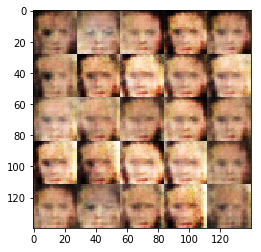

Bacth 1010: Epoch 1/1... Discriminator Loss: 1.2569... Generator Loss: 1.5923
Bacth 1020: Epoch 1/1... Discriminator Loss: 1.3344... Generator Loss: 1.0567
Bacth 1030: Epoch 1/1... Discriminator Loss: 1.3280... Generator Loss: 1.2724
Bacth 1040: Epoch 1/1... Discriminator Loss: 1.3777... Generator Loss: 0.9494
Bacth 1050: Epoch 1/1... Discriminator Loss: 1.2618... Generator Loss: 1.8399
Bacth 1060: Epoch 1/1... Discriminator Loss: 1.6660... Generator Loss: 1.8197
Bacth 1070: Epoch 1/1... Discriminator Loss: 1.1545... Generator Loss: 1.0425
Bacth 1080: Epoch 1/1... Discriminator Loss: 1.4846... Generator Loss: 1.9460
Bacth 1090: Epoch 1/1... Discriminator Loss: 1.3493... Generator Loss: 1.4458
Bacth 1100: Epoch 1/1... Discriminator Loss: 1.2438... Generator Loss: 1.2234


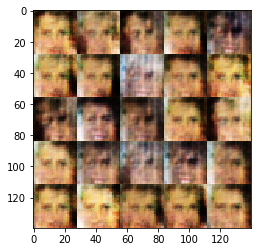

Bacth 1110: Epoch 1/1... Discriminator Loss: 1.4147... Generator Loss: 1.3248
Bacth 1120: Epoch 1/1... Discriminator Loss: 1.4613... Generator Loss: 0.9106
Bacth 1130: Epoch 1/1... Discriminator Loss: 1.5032... Generator Loss: 0.8245
Bacth 1140: Epoch 1/1... Discriminator Loss: 0.9426... Generator Loss: 2.2748
Bacth 1150: Epoch 1/1... Discriminator Loss: 1.7777... Generator Loss: 0.6250
Bacth 1160: Epoch 1/1... Discriminator Loss: 0.8124... Generator Loss: 1.9265
Bacth 1170: Epoch 1/1... Discriminator Loss: 1.1414... Generator Loss: 1.1168
Bacth 1180: Epoch 1/1... Discriminator Loss: 1.2742... Generator Loss: 2.2298
Bacth 1190: Epoch 1/1... Discriminator Loss: 1.4491... Generator Loss: 1.3492
Bacth 1200: Epoch 1/1... Discriminator Loss: 1.4039... Generator Loss: 0.9666


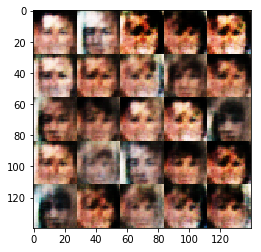

Bacth 1210: Epoch 1/1... Discriminator Loss: 1.0975... Generator Loss: 1.8626
Bacth 1220: Epoch 1/1... Discriminator Loss: 1.4286... Generator Loss: 0.9265
Bacth 1230: Epoch 1/1... Discriminator Loss: 1.2154... Generator Loss: 1.5997
Bacth 1240: Epoch 1/1... Discriminator Loss: 1.5139... Generator Loss: 1.2901
Bacth 1250: Epoch 1/1... Discriminator Loss: 1.6547... Generator Loss: 1.2735
Bacth 1260: Epoch 1/1... Discriminator Loss: 1.6295... Generator Loss: 1.4532
Bacth 1270: Epoch 1/1... Discriminator Loss: 1.3046... Generator Loss: 1.2320
Bacth 1280: Epoch 1/1... Discriminator Loss: 1.2504... Generator Loss: 1.2489
Bacth 1290: Epoch 1/1... Discriminator Loss: 1.4642... Generator Loss: 1.1444
Bacth 1300: Epoch 1/1... Discriminator Loss: 1.3315... Generator Loss: 1.2555


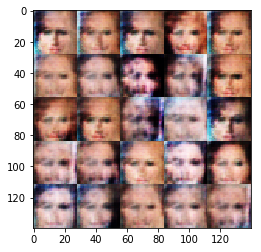

Bacth 1310: Epoch 1/1... Discriminator Loss: 1.1789... Generator Loss: 1.3159
Bacth 1320: Epoch 1/1... Discriminator Loss: 1.4706... Generator Loss: 1.4345
Bacth 1330: Epoch 1/1... Discriminator Loss: 1.5273... Generator Loss: 1.5359
Bacth 1340: Epoch 1/1... Discriminator Loss: 1.1487... Generator Loss: 1.1985
Bacth 1350: Epoch 1/1... Discriminator Loss: 1.3729... Generator Loss: 1.9706
Bacth 1360: Epoch 1/1... Discriminator Loss: 1.4962... Generator Loss: 1.1512
Bacth 1370: Epoch 1/1... Discriminator Loss: 1.4061... Generator Loss: 0.7432
Bacth 1380: Epoch 1/1... Discriminator Loss: 1.1705... Generator Loss: 1.0813
Bacth 1390: Epoch 1/1... Discriminator Loss: 1.3766... Generator Loss: 0.8725
Bacth 1400: Epoch 1/1... Discriminator Loss: 0.9353... Generator Loss: 1.8250


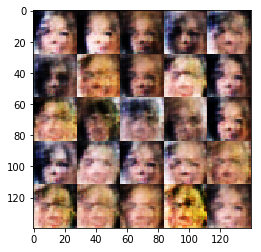

Bacth 1410: Epoch 1/1... Discriminator Loss: 1.6546... Generator Loss: 0.8948
Bacth 1420: Epoch 1/1... Discriminator Loss: 1.2159... Generator Loss: 1.5270
Bacth 1430: Epoch 1/1... Discriminator Loss: 1.7366... Generator Loss: 1.9422
Bacth 1440: Epoch 1/1... Discriminator Loss: 1.2862... Generator Loss: 0.9605
Bacth 1450: Epoch 1/1... Discriminator Loss: 1.3298... Generator Loss: 1.9410
Bacth 1460: Epoch 1/1... Discriminator Loss: 1.3258... Generator Loss: 0.9822
Bacth 1470: Epoch 1/1... Discriminator Loss: 1.0911... Generator Loss: 1.1875
Bacth 1480: Epoch 1/1... Discriminator Loss: 1.2733... Generator Loss: 1.0506
Bacth 1490: Epoch 1/1... Discriminator Loss: 1.4807... Generator Loss: 0.9747
Bacth 1500: Epoch 1/1... Discriminator Loss: 1.3649... Generator Loss: 1.5794


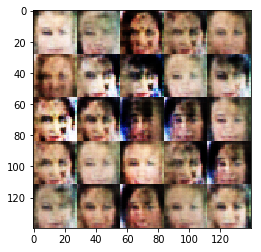

Bacth 1510: Epoch 1/1... Discriminator Loss: 1.1800... Generator Loss: 1.2920
Bacth 1520: Epoch 1/1... Discriminator Loss: 1.5936... Generator Loss: 1.4215
Bacth 1530: Epoch 1/1... Discriminator Loss: 1.4922... Generator Loss: 0.9720
Bacth 1540: Epoch 1/1... Discriminator Loss: 1.5044... Generator Loss: 0.7322
Bacth 1550: Epoch 1/1... Discriminator Loss: 1.2178... Generator Loss: 1.0586
Bacth 1560: Epoch 1/1... Discriminator Loss: 1.0729... Generator Loss: 1.6415
Bacth 1570: Epoch 1/1... Discriminator Loss: 1.1729... Generator Loss: 1.1707
Bacth 1580: Epoch 1/1... Discriminator Loss: 1.4511... Generator Loss: 0.7687
Bacth 1590: Epoch 1/1... Discriminator Loss: 1.2892... Generator Loss: 1.0984
Bacth 1600: Epoch 1/1... Discriminator Loss: 1.1659... Generator Loss: 2.1089


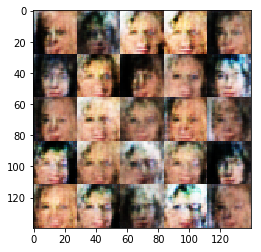

Bacth 1610: Epoch 1/1... Discriminator Loss: 1.3057... Generator Loss: 0.6463
Bacth 1620: Epoch 1/1... Discriminator Loss: 0.9974... Generator Loss: 1.1325
Bacth 1630: Epoch 1/1... Discriminator Loss: 0.9132... Generator Loss: 1.9583
Bacth 1640: Epoch 1/1... Discriminator Loss: 1.0170... Generator Loss: 1.2798
Bacth 1650: Epoch 1/1... Discriminator Loss: 1.2158... Generator Loss: 0.9503
Bacth 1660: Epoch 1/1... Discriminator Loss: 1.2003... Generator Loss: 0.9443
Bacth 1670: Epoch 1/1... Discriminator Loss: 1.3058... Generator Loss: 0.7999
Bacth 1680: Epoch 1/1... Discriminator Loss: 1.1381... Generator Loss: 1.1104
Bacth 1690: Epoch 1/1... Discriminator Loss: 1.3131... Generator Loss: 0.7971
Bacth 1700: Epoch 1/1... Discriminator Loss: 1.3129... Generator Loss: 0.9383


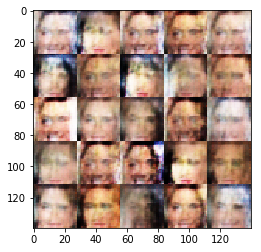

Bacth 1710: Epoch 1/1... Discriminator Loss: 1.5025... Generator Loss: 0.7887
Bacth 1720: Epoch 1/1... Discriminator Loss: 0.9310... Generator Loss: 1.5770
Bacth 1730: Epoch 1/1... Discriminator Loss: 1.1749... Generator Loss: 1.0030
Bacth 1740: Epoch 1/1... Discriminator Loss: 1.0362... Generator Loss: 1.1992
Bacth 1750: Epoch 1/1... Discriminator Loss: 1.3333... Generator Loss: 1.3780
Bacth 1760: Epoch 1/1... Discriminator Loss: 1.0468... Generator Loss: 1.5208
Bacth 1770: Epoch 1/1... Discriminator Loss: 1.3421... Generator Loss: 0.9709
Bacth 1780: Epoch 1/1... Discriminator Loss: 1.2077... Generator Loss: 2.0377
Bacth 1790: Epoch 1/1... Discriminator Loss: 1.3978... Generator Loss: 1.2798
Bacth 1800: Epoch 1/1... Discriminator Loss: 1.3566... Generator Loss: 2.1581


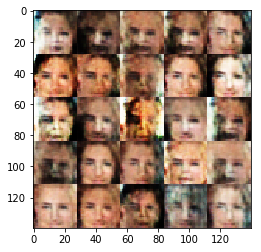

Bacth 1810: Epoch 1/1... Discriminator Loss: 1.5346... Generator Loss: 0.8027
Bacth 1820: Epoch 1/1... Discriminator Loss: 0.8119... Generator Loss: 1.7673
Bacth 1830: Epoch 1/1... Discriminator Loss: 1.5728... Generator Loss: 1.2398
Bacth 1840: Epoch 1/1... Discriminator Loss: 1.2231... Generator Loss: 1.1712
Bacth 1850: Epoch 1/1... Discriminator Loss: 1.1891... Generator Loss: 1.5118
Bacth 1860: Epoch 1/1... Discriminator Loss: 1.2824... Generator Loss: 0.9340
Bacth 1870: Epoch 1/1... Discriminator Loss: 1.2645... Generator Loss: 0.9836
Bacth 1880: Epoch 1/1... Discriminator Loss: 1.3389... Generator Loss: 0.9807
Bacth 1890: Epoch 1/1... Discriminator Loss: 1.2326... Generator Loss: 1.1847
Bacth 1900: Epoch 1/1... Discriminator Loss: 1.3698... Generator Loss: 1.3682


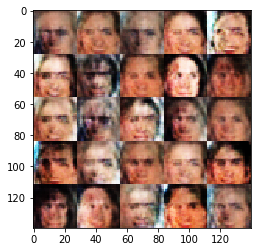

Bacth 1910: Epoch 1/1... Discriminator Loss: 1.1527... Generator Loss: 0.9025
Bacth 1920: Epoch 1/1... Discriminator Loss: 1.0060... Generator Loss: 1.4171
Bacth 1930: Epoch 1/1... Discriminator Loss: 1.0925... Generator Loss: 0.9821
Bacth 1940: Epoch 1/1... Discriminator Loss: 1.1712... Generator Loss: 1.1962
Bacth 1950: Epoch 1/1... Discriminator Loss: 1.6967... Generator Loss: 0.5103
Bacth 1960: Epoch 1/1... Discriminator Loss: 1.0775... Generator Loss: 1.3542
Bacth 1970: Epoch 1/1... Discriminator Loss: 1.3183... Generator Loss: 1.6131
Bacth 1980: Epoch 1/1... Discriminator Loss: 1.3497... Generator Loss: 1.0190
Bacth 1990: Epoch 1/1... Discriminator Loss: 0.9180... Generator Loss: 1.5015
Bacth 2000: Epoch 1/1... Discriminator Loss: 1.6082... Generator Loss: 0.5556


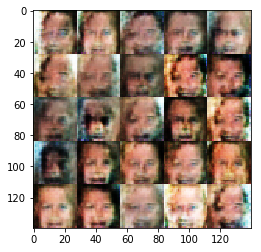

Bacth 2010: Epoch 1/1... Discriminator Loss: 0.9124... Generator Loss: 1.7917
Bacth 2020: Epoch 1/1... Discriminator Loss: 1.1084... Generator Loss: 1.7434
Bacth 2030: Epoch 1/1... Discriminator Loss: 1.0768... Generator Loss: 2.2859
Bacth 2040: Epoch 1/1... Discriminator Loss: 1.1741... Generator Loss: 1.2734
Bacth 2050: Epoch 1/1... Discriminator Loss: 1.1136... Generator Loss: 1.4191
Bacth 2060: Epoch 1/1... Discriminator Loss: 1.1276... Generator Loss: 0.9929
Bacth 2070: Epoch 1/1... Discriminator Loss: 1.2534... Generator Loss: 1.3003
Bacth 2080: Epoch 1/1... Discriminator Loss: 1.0136... Generator Loss: 1.8729
Bacth 2090: Epoch 1/1... Discriminator Loss: 0.9954... Generator Loss: 1.5881
Bacth 2100: Epoch 1/1... Discriminator Loss: 1.1839... Generator Loss: 1.1354


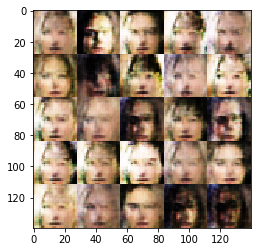

Bacth 2110: Epoch 1/1... Discriminator Loss: 1.8549... Generator Loss: 1.3978
Bacth 2120: Epoch 1/1... Discriminator Loss: 1.5549... Generator Loss: 1.4651
Bacth 2130: Epoch 1/1... Discriminator Loss: 1.3410... Generator Loss: 0.7147
Bacth 2140: Epoch 1/1... Discriminator Loss: 1.0870... Generator Loss: 1.9530
Bacth 2150: Epoch 1/1... Discriminator Loss: 1.1859... Generator Loss: 1.6480
Bacth 2160: Epoch 1/1... Discriminator Loss: 1.1180... Generator Loss: 1.2247
Bacth 2170: Epoch 1/1... Discriminator Loss: 0.8910... Generator Loss: 1.6743
Bacth 2180: Epoch 1/1... Discriminator Loss: 1.0796... Generator Loss: 1.4120
Bacth 2190: Epoch 1/1... Discriminator Loss: 1.0129... Generator Loss: 1.4695
Bacth 2200: Epoch 1/1... Discriminator Loss: 0.9903... Generator Loss: 1.9507


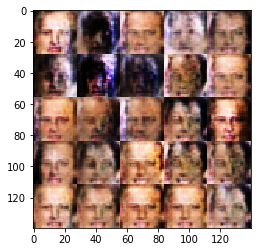

Bacth 2210: Epoch 1/1... Discriminator Loss: 1.2847... Generator Loss: 1.9912
Bacth 2220: Epoch 1/1... Discriminator Loss: 1.1542... Generator Loss: 1.4230
Bacth 2230: Epoch 1/1... Discriminator Loss: 1.1818... Generator Loss: 0.9012
Bacth 2240: Epoch 1/1... Discriminator Loss: 1.1510... Generator Loss: 1.3649
Bacth 2250: Epoch 1/1... Discriminator Loss: 0.9520... Generator Loss: 1.9082
Bacth 2260: Epoch 1/1... Discriminator Loss: 1.1957... Generator Loss: 1.2611
Bacth 2270: Epoch 1/1... Discriminator Loss: 1.3269... Generator Loss: 1.2923
Bacth 2280: Epoch 1/1... Discriminator Loss: 1.1831... Generator Loss: 2.0508
Bacth 2290: Epoch 1/1... Discriminator Loss: 1.2670... Generator Loss: 0.9315
Bacth 2300: Epoch 1/1... Discriminator Loss: 1.2937... Generator Loss: 2.4212


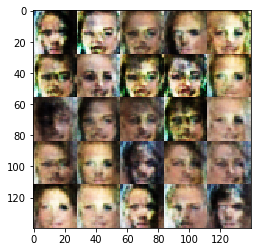

Bacth 2310: Epoch 1/1... Discriminator Loss: 1.3342... Generator Loss: 1.0071
Bacth 2320: Epoch 1/1... Discriminator Loss: 1.4147... Generator Loss: 1.4183
Bacth 2330: Epoch 1/1... Discriminator Loss: 1.4176... Generator Loss: 1.8706
Bacth 2340: Epoch 1/1... Discriminator Loss: 1.2284... Generator Loss: 1.3807
Bacth 2350: Epoch 1/1... Discriminator Loss: 1.1627... Generator Loss: 1.9039
Bacth 2360: Epoch 1/1... Discriminator Loss: 0.7671... Generator Loss: 2.3328
Bacth 2370: Epoch 1/1... Discriminator Loss: 1.4339... Generator Loss: 0.8090
Bacth 2380: Epoch 1/1... Discriminator Loss: 1.1372... Generator Loss: 1.1687
Bacth 2390: Epoch 1/1... Discriminator Loss: 1.0588... Generator Loss: 1.8575
Bacth 2400: Epoch 1/1... Discriminator Loss: 1.1287... Generator Loss: 1.3917


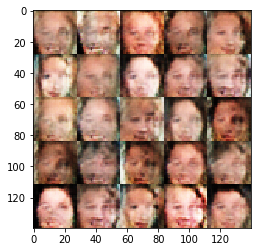

Bacth 2410: Epoch 1/1... Discriminator Loss: 1.0213... Generator Loss: 0.9826
Bacth 2420: Epoch 1/1... Discriminator Loss: 1.4742... Generator Loss: 2.9440
Bacth 2430: Epoch 1/1... Discriminator Loss: 1.2450... Generator Loss: 1.2647
Bacth 2440: Epoch 1/1... Discriminator Loss: 1.2500... Generator Loss: 0.8540
Bacth 2450: Epoch 1/1... Discriminator Loss: 1.3377... Generator Loss: 1.1142
Bacth 2460: Epoch 1/1... Discriminator Loss: 1.7510... Generator Loss: 1.7716
Bacth 2470: Epoch 1/1... Discriminator Loss: 1.1516... Generator Loss: 1.8054
Bacth 2480: Epoch 1/1... Discriminator Loss: 1.3941... Generator Loss: 1.1392
Bacth 2490: Epoch 1/1... Discriminator Loss: 1.2115... Generator Loss: 2.0149
Bacth 2500: Epoch 1/1... Discriminator Loss: 1.2855... Generator Loss: 2.1802


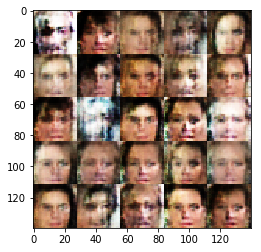

Bacth 2510: Epoch 1/1... Discriminator Loss: 1.2277... Generator Loss: 2.0659
Bacth 2520: Epoch 1/1... Discriminator Loss: 1.1118... Generator Loss: 0.8504
Bacth 2530: Epoch 1/1... Discriminator Loss: 1.0993... Generator Loss: 1.9014
Bacth 2540: Epoch 1/1... Discriminator Loss: 1.1942... Generator Loss: 1.0701
Bacth 2550: Epoch 1/1... Discriminator Loss: 1.1448... Generator Loss: 1.3072
Bacth 2560: Epoch 1/1... Discriminator Loss: 1.1321... Generator Loss: 1.2289
Bacth 2570: Epoch 1/1... Discriminator Loss: 1.0937... Generator Loss: 1.5795
Bacth 2580: Epoch 1/1... Discriminator Loss: 1.2403... Generator Loss: 1.5536
Bacth 2590: Epoch 1/1... Discriminator Loss: 1.1715... Generator Loss: 1.3263
Bacth 2600: Epoch 1/1... Discriminator Loss: 0.9826... Generator Loss: 1.8048


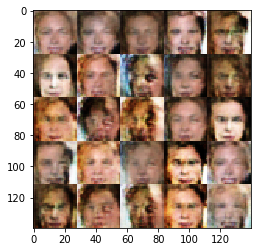

Bacth 2610: Epoch 1/1... Discriminator Loss: 1.1180... Generator Loss: 1.8313
Bacth 2620: Epoch 1/1... Discriminator Loss: 1.0284... Generator Loss: 1.7265
Bacth 2630: Epoch 1/1... Discriminator Loss: 1.1212... Generator Loss: 0.9919
Bacth 2640: Epoch 1/1... Discriminator Loss: 1.0122... Generator Loss: 1.4433
Bacth 2650: Epoch 1/1... Discriminator Loss: 0.8987... Generator Loss: 1.5108
Bacth 2660: Epoch 1/1... Discriminator Loss: 1.2696... Generator Loss: 0.6832
Bacth 2670: Epoch 1/1... Discriminator Loss: 0.8262... Generator Loss: 1.5477
Bacth 2680: Epoch 1/1... Discriminator Loss: 1.1798... Generator Loss: 1.0731
Bacth 2690: Epoch 1/1... Discriminator Loss: 1.0730... Generator Loss: 1.7235
Bacth 2700: Epoch 1/1... Discriminator Loss: 1.0789... Generator Loss: 1.1023


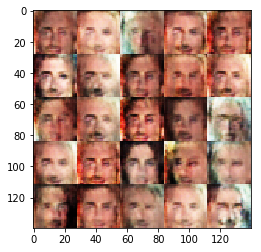

Bacth 2710: Epoch 1/1... Discriminator Loss: 1.1675... Generator Loss: 0.9381
Bacth 2720: Epoch 1/1... Discriminator Loss: 0.9934... Generator Loss: 1.3597
Bacth 2730: Epoch 1/1... Discriminator Loss: 1.1042... Generator Loss: 1.5700
Bacth 2740: Epoch 1/1... Discriminator Loss: 1.1355... Generator Loss: 1.3209
Bacth 2750: Epoch 1/1... Discriminator Loss: 1.2348... Generator Loss: 0.6918
Bacth 2760: Epoch 1/1... Discriminator Loss: 1.2356... Generator Loss: 1.6979
Bacth 2770: Epoch 1/1... Discriminator Loss: 1.0205... Generator Loss: 1.4848
Bacth 2780: Epoch 1/1... Discriminator Loss: 1.2666... Generator Loss: 1.6391
Bacth 2790: Epoch 1/1... Discriminator Loss: 1.2553... Generator Loss: 1.3094
Bacth 2800: Epoch 1/1... Discriminator Loss: 0.9605... Generator Loss: 2.3666


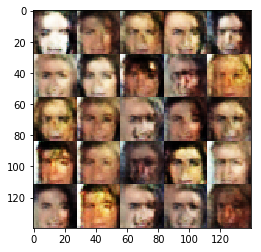

Bacth 2810: Epoch 1/1... Discriminator Loss: 0.9217... Generator Loss: 1.7416
Bacth 2820: Epoch 1/1... Discriminator Loss: 1.1080... Generator Loss: 1.1952
Bacth 2830: Epoch 1/1... Discriminator Loss: 1.2642... Generator Loss: 0.7994
Bacth 2840: Epoch 1/1... Discriminator Loss: 1.1440... Generator Loss: 1.3442
Bacth 2850: Epoch 1/1... Discriminator Loss: 1.1211... Generator Loss: 1.6330
Bacth 2860: Epoch 1/1... Discriminator Loss: 1.2741... Generator Loss: 1.0461
Bacth 2870: Epoch 1/1... Discriminator Loss: 0.9046... Generator Loss: 1.7541
Bacth 2880: Epoch 1/1... Discriminator Loss: 1.3984... Generator Loss: 0.6857
Bacth 2890: Epoch 1/1... Discriminator Loss: 0.7865... Generator Loss: 2.0039
Bacth 2900: Epoch 1/1... Discriminator Loss: 1.3086... Generator Loss: 0.9397


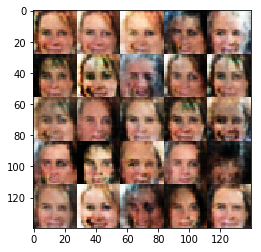

Bacth 2910: Epoch 1/1... Discriminator Loss: 1.3099... Generator Loss: 2.3565
Bacth 2920: Epoch 1/1... Discriminator Loss: 1.5325... Generator Loss: 0.4727
Bacth 2930: Epoch 1/1... Discriminator Loss: 0.8784... Generator Loss: 1.3593
Bacth 2940: Epoch 1/1... Discriminator Loss: 0.9794... Generator Loss: 1.2704
Bacth 2950: Epoch 1/1... Discriminator Loss: 1.0057... Generator Loss: 1.7100
Bacth 2960: Epoch 1/1... Discriminator Loss: 1.5220... Generator Loss: 0.7343
Bacth 2970: Epoch 1/1... Discriminator Loss: 1.4405... Generator Loss: 0.7989
Bacth 2980: Epoch 1/1... Discriminator Loss: 1.1576... Generator Loss: 1.1691
Bacth 2990: Epoch 1/1... Discriminator Loss: 0.9355... Generator Loss: 1.6735
Bacth 3000: Epoch 1/1... Discriminator Loss: 1.1274... Generator Loss: 1.7429


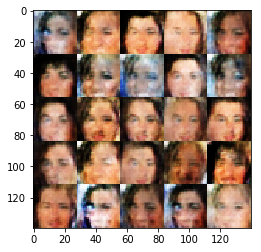

Bacth 3010: Epoch 1/1... Discriminator Loss: 1.2010... Generator Loss: 2.3000
Bacth 3020: Epoch 1/1... Discriminator Loss: 1.3329... Generator Loss: 1.3241
Bacth 3030: Epoch 1/1... Discriminator Loss: 1.1307... Generator Loss: 1.1524
Bacth 3040: Epoch 1/1... Discriminator Loss: 1.2106... Generator Loss: 1.0949
Bacth 3050: Epoch 1/1... Discriminator Loss: 1.0251... Generator Loss: 1.5298
Bacth 3060: Epoch 1/1... Discriminator Loss: 1.2901... Generator Loss: 1.3436
Bacth 3070: Epoch 1/1... Discriminator Loss: 1.1073... Generator Loss: 1.2852
Bacth 3080: Epoch 1/1... Discriminator Loss: 1.3894... Generator Loss: 1.4496
Bacth 3090: Epoch 1/1... Discriminator Loss: 1.4745... Generator Loss: 1.2865
Bacth 3100: Epoch 1/1... Discriminator Loss: 1.0383... Generator Loss: 0.8660


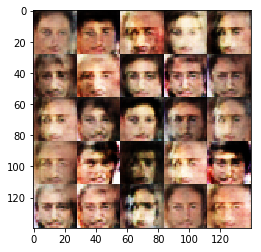

Bacth 3110: Epoch 1/1... Discriminator Loss: 1.0587... Generator Loss: 1.6608
Bacth 3120: Epoch 1/1... Discriminator Loss: 1.1480... Generator Loss: 1.5147
Bacth 3130: Epoch 1/1... Discriminator Loss: 1.0070... Generator Loss: 1.4749
Bacth 3140: Epoch 1/1... Discriminator Loss: 1.1424... Generator Loss: 1.2423
Bacth 3150: Epoch 1/1... Discriminator Loss: 1.3921... Generator Loss: 1.0322
Bacth 3160: Epoch 1/1... Discriminator Loss: 1.4517... Generator Loss: 0.5523
Bacth 3170: Epoch 1/1... Discriminator Loss: 1.5817... Generator Loss: 1.0755
Bacth 3180: Epoch 1/1... Discriminator Loss: 1.4102... Generator Loss: 1.0952
Bacth 3190: Epoch 1/1... Discriminator Loss: 1.2122... Generator Loss: 1.8946
Bacth 3200: Epoch 1/1... Discriminator Loss: 1.1307... Generator Loss: 1.8084


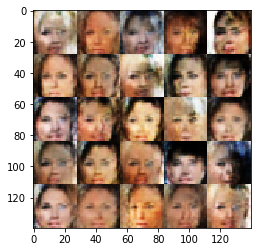

Bacth 3210: Epoch 1/1... Discriminator Loss: 1.0319... Generator Loss: 1.3798
Bacth 3220: Epoch 1/1... Discriminator Loss: 1.0966... Generator Loss: 1.3350
Bacth 3230: Epoch 1/1... Discriminator Loss: 1.2956... Generator Loss: 1.8890
Bacth 3240: Epoch 1/1... Discriminator Loss: 1.1062... Generator Loss: 1.4579
Bacth 3250: Epoch 1/1... Discriminator Loss: 1.2393... Generator Loss: 0.8677
Bacth 3260: Epoch 1/1... Discriminator Loss: 1.1012... Generator Loss: 1.1957
Bacth 3270: Epoch 1/1... Discriminator Loss: 1.1021... Generator Loss: 1.1894
Bacth 3280: Epoch 1/1... Discriminator Loss: 1.0829... Generator Loss: 1.0535
Bacth 3290: Epoch 1/1... Discriminator Loss: 1.1949... Generator Loss: 2.0025
Bacth 3300: Epoch 1/1... Discriminator Loss: 0.9115... Generator Loss: 2.0472


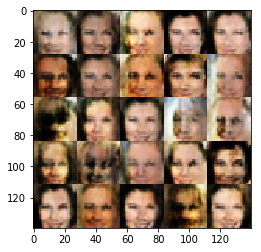

Bacth 3310: Epoch 1/1... Discriminator Loss: 1.1879... Generator Loss: 0.9486
Bacth 3320: Epoch 1/1... Discriminator Loss: 1.0546... Generator Loss: 1.1226
Bacth 3330: Epoch 1/1... Discriminator Loss: 1.0012... Generator Loss: 2.0077
Bacth 3340: Epoch 1/1... Discriminator Loss: 0.7515... Generator Loss: 1.9799
Bacth 3350: Epoch 1/1... Discriminator Loss: 0.9271... Generator Loss: 2.1879
Bacth 3360: Epoch 1/1... Discriminator Loss: 1.2295... Generator Loss: 0.9400
Bacth 3370: Epoch 1/1... Discriminator Loss: 1.0863... Generator Loss: 1.5530
Bacth 3380: Epoch 1/1... Discriminator Loss: 1.2303... Generator Loss: 2.0018
Bacth 3390: Epoch 1/1... Discriminator Loss: 1.7740... Generator Loss: 0.9943
Bacth 3400: Epoch 1/1... Discriminator Loss: 1.1938... Generator Loss: 1.7169


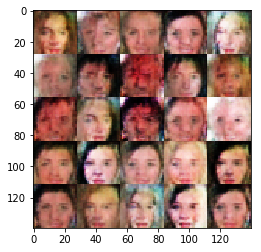

Bacth 3410: Epoch 1/1... Discriminator Loss: 1.1953... Generator Loss: 1.1119
Bacth 3420: Epoch 1/1... Discriminator Loss: 1.1833... Generator Loss: 0.8347
Bacth 3430: Epoch 1/1... Discriminator Loss: 1.4066... Generator Loss: 0.6557
Bacth 3440: Epoch 1/1... Discriminator Loss: 1.0218... Generator Loss: 1.0833
Bacth 3450: Epoch 1/1... Discriminator Loss: 1.3598... Generator Loss: 0.7511
Bacth 3460: Epoch 1/1... Discriminator Loss: 1.0481... Generator Loss: 1.2409
Bacth 3470: Epoch 1/1... Discriminator Loss: 1.2159... Generator Loss: 1.4734
Bacth 3480: Epoch 1/1... Discriminator Loss: 1.0044... Generator Loss: 1.5375
Bacth 3490: Epoch 1/1... Discriminator Loss: 0.8564... Generator Loss: 1.3675
Bacth 3500: Epoch 1/1... Discriminator Loss: 1.1478... Generator Loss: 1.4781


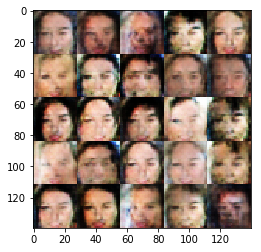

Bacth 3510: Epoch 1/1... Discriminator Loss: 0.7826... Generator Loss: 1.5659
Bacth 3520: Epoch 1/1... Discriminator Loss: 1.0918... Generator Loss: 1.5718
Bacth 3530: Epoch 1/1... Discriminator Loss: 1.1281... Generator Loss: 1.5809
Bacth 3540: Epoch 1/1... Discriminator Loss: 1.6172... Generator Loss: 1.6885
Bacth 3550: Epoch 1/1... Discriminator Loss: 0.9612... Generator Loss: 1.9046
Bacth 3560: Epoch 1/1... Discriminator Loss: 0.8089... Generator Loss: 2.7204
Bacth 3570: Epoch 1/1... Discriminator Loss: 1.0080... Generator Loss: 2.3964
Bacth 3580: Epoch 1/1... Discriminator Loss: 0.9591... Generator Loss: 1.3812
Bacth 3590: Epoch 1/1... Discriminator Loss: 1.1858... Generator Loss: 1.1915
Bacth 3600: Epoch 1/1... Discriminator Loss: 0.9370... Generator Loss: 1.8263


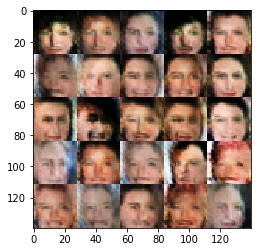

Bacth 3610: Epoch 1/1... Discriminator Loss: 1.0578... Generator Loss: 1.0209
Bacth 3620: Epoch 1/1... Discriminator Loss: 1.2058... Generator Loss: 1.3381
Bacth 3630: Epoch 1/1... Discriminator Loss: 1.2675... Generator Loss: 0.9082
Bacth 3640: Epoch 1/1... Discriminator Loss: 0.9634... Generator Loss: 1.8884
Bacth 3650: Epoch 1/1... Discriminator Loss: 0.8302... Generator Loss: 1.9782
Bacth 3660: Epoch 1/1... Discriminator Loss: 0.9320... Generator Loss: 1.3029
Bacth 3670: Epoch 1/1... Discriminator Loss: 1.0320... Generator Loss: 1.1135
Bacth 3680: Epoch 1/1... Discriminator Loss: 0.9944... Generator Loss: 1.8967
Bacth 3690: Epoch 1/1... Discriminator Loss: 1.0617... Generator Loss: 1.1787
Bacth 3700: Epoch 1/1... Discriminator Loss: 0.9744... Generator Loss: 1.1419


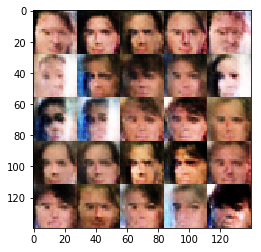

Bacth 3710: Epoch 1/1... Discriminator Loss: 0.9464... Generator Loss: 1.2317
Bacth 3720: Epoch 1/1... Discriminator Loss: 0.9059... Generator Loss: 1.8494
Bacth 3730: Epoch 1/1... Discriminator Loss: 0.9300... Generator Loss: 1.3983
Bacth 3740: Epoch 1/1... Discriminator Loss: 1.0265... Generator Loss: 1.4014
Bacth 3750: Epoch 1/1... Discriminator Loss: 1.0631... Generator Loss: 1.8207
Bacth 3760: Epoch 1/1... Discriminator Loss: 1.1161... Generator Loss: 0.9523
Bacth 3770: Epoch 1/1... Discriminator Loss: 1.1219... Generator Loss: 1.0804
Bacth 3780: Epoch 1/1... Discriminator Loss: 0.9803... Generator Loss: 1.3712
Bacth 3790: Epoch 1/1... Discriminator Loss: 1.1448... Generator Loss: 1.0357
Bacth 3800: Epoch 1/1... Discriminator Loss: 0.9721... Generator Loss: 1.3968


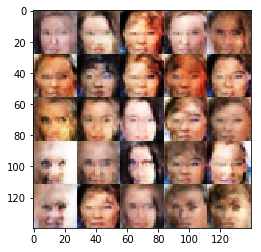

Bacth 3810: Epoch 1/1... Discriminator Loss: 1.1198... Generator Loss: 1.9513
Bacth 3820: Epoch 1/1... Discriminator Loss: 1.1221... Generator Loss: 1.1308
Bacth 3830: Epoch 1/1... Discriminator Loss: 1.1483... Generator Loss: 1.8676
Bacth 3840: Epoch 1/1... Discriminator Loss: 1.0297... Generator Loss: 1.1398
Bacth 3850: Epoch 1/1... Discriminator Loss: 0.9935... Generator Loss: 2.0652
Bacth 3860: Epoch 1/1... Discriminator Loss: 1.2181... Generator Loss: 0.9573
Bacth 3870: Epoch 1/1... Discriminator Loss: 1.1764... Generator Loss: 1.2565
Bacth 3880: Epoch 1/1... Discriminator Loss: 1.0229... Generator Loss: 2.1867
Bacth 3890: Epoch 1/1... Discriminator Loss: 1.0479... Generator Loss: 1.5696
Bacth 3900: Epoch 1/1... Discriminator Loss: 1.0523... Generator Loss: 1.4477


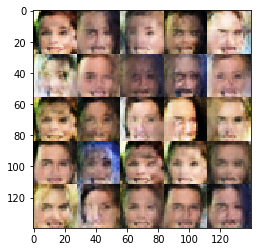

Bacth 3910: Epoch 1/1... Discriminator Loss: 0.9391... Generator Loss: 1.6675
Bacth 3920: Epoch 1/1... Discriminator Loss: 1.0339... Generator Loss: 1.7061
Bacth 3930: Epoch 1/1... Discriminator Loss: 1.5780... Generator Loss: 0.4929
Bacth 3940: Epoch 1/1... Discriminator Loss: 1.4326... Generator Loss: 0.6964
Bacth 3950: Epoch 1/1... Discriminator Loss: 0.9780... Generator Loss: 1.2748
Bacth 3960: Epoch 1/1... Discriminator Loss: 1.1067... Generator Loss: 0.8726
Bacth 3970: Epoch 1/1... Discriminator Loss: 1.2984... Generator Loss: 1.0870
Bacth 3980: Epoch 1/1... Discriminator Loss: 0.9521... Generator Loss: 1.3412
Bacth 3990: Epoch 1/1... Discriminator Loss: 1.1241... Generator Loss: 0.9366
Bacth 4000: Epoch 1/1... Discriminator Loss: 1.0836... Generator Loss: 2.1995


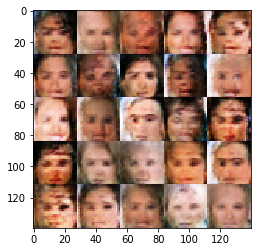

Bacth 4010: Epoch 1/1... Discriminator Loss: 1.2770... Generator Loss: 1.5928
Bacth 4020: Epoch 1/1... Discriminator Loss: 1.5132... Generator Loss: 1.7234
Bacth 4030: Epoch 1/1... Discriminator Loss: 1.1152... Generator Loss: 1.6359
Bacth 4040: Epoch 1/1... Discriminator Loss: 1.1737... Generator Loss: 1.5568
Bacth 4050: Epoch 1/1... Discriminator Loss: 1.3985... Generator Loss: 1.1708
Bacth 4060: Epoch 1/1... Discriminator Loss: 1.3110... Generator Loss: 1.0811
Bacth 4070: Epoch 1/1... Discriminator Loss: 1.1214... Generator Loss: 1.4476
Bacth 4080: Epoch 1/1... Discriminator Loss: 1.1170... Generator Loss: 1.3244
Bacth 4090: Epoch 1/1... Discriminator Loss: 1.2127... Generator Loss: 1.5293
Bacth 4100: Epoch 1/1... Discriminator Loss: 1.0054... Generator Loss: 1.3929


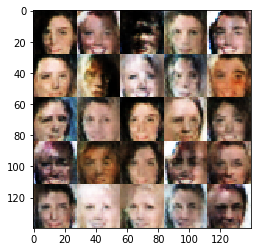

Bacth 4110: Epoch 1/1... Discriminator Loss: 0.9425... Generator Loss: 2.2929
Bacth 4120: Epoch 1/1... Discriminator Loss: 1.2270... Generator Loss: 0.8926
Bacth 4130: Epoch 1/1... Discriminator Loss: 1.1699... Generator Loss: 1.2160
Bacth 4140: Epoch 1/1... Discriminator Loss: 1.0293... Generator Loss: 1.6274
Bacth 4150: Epoch 1/1... Discriminator Loss: 1.0590... Generator Loss: 1.5515
Bacth 4160: Epoch 1/1... Discriminator Loss: 1.0182... Generator Loss: 1.1016
Bacth 4170: Epoch 1/1... Discriminator Loss: 1.1838... Generator Loss: 1.1721
Bacth 4180: Epoch 1/1... Discriminator Loss: 1.2444... Generator Loss: 1.7753
Bacth 4190: Epoch 1/1... Discriminator Loss: 1.1240... Generator Loss: 2.0062
Bacth 4200: Epoch 1/1... Discriminator Loss: 1.0290... Generator Loss: 1.8074


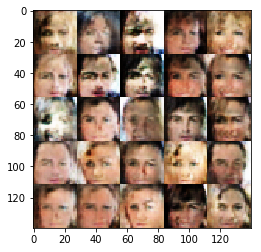

Bacth 4210: Epoch 1/1... Discriminator Loss: 1.1509... Generator Loss: 1.4956
Bacth 4220: Epoch 1/1... Discriminator Loss: 1.4125... Generator Loss: 1.0067
Bacth 4230: Epoch 1/1... Discriminator Loss: 1.4849... Generator Loss: 0.9733
Bacth 4240: Epoch 1/1... Discriminator Loss: 1.3251... Generator Loss: 1.6764
Bacth 4250: Epoch 1/1... Discriminator Loss: 1.1324... Generator Loss: 1.0269
Bacth 4260: Epoch 1/1... Discriminator Loss: 0.9927... Generator Loss: 2.1589
Bacth 4270: Epoch 1/1... Discriminator Loss: 1.3085... Generator Loss: 0.7170
Bacth 4280: Epoch 1/1... Discriminator Loss: 1.0287... Generator Loss: 0.8893
Bacth 4290: Epoch 1/1... Discriminator Loss: 0.8561... Generator Loss: 1.5986
Bacth 4300: Epoch 1/1... Discriminator Loss: 0.8331... Generator Loss: 1.5644


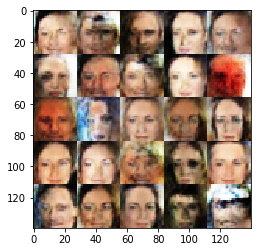

Bacth 4310: Epoch 1/1... Discriminator Loss: 1.2499... Generator Loss: 0.7519
Bacth 4320: Epoch 1/1... Discriminator Loss: 1.0657... Generator Loss: 1.3549
Bacth 4330: Epoch 1/1... Discriminator Loss: 0.7634... Generator Loss: 1.7090
Bacth 4340: Epoch 1/1... Discriminator Loss: 1.2866... Generator Loss: 0.7800
Bacth 4350: Epoch 1/1... Discriminator Loss: 0.8244... Generator Loss: 1.8427
Bacth 4360: Epoch 1/1... Discriminator Loss: 0.8616... Generator Loss: 1.8550
Bacth 4370: Epoch 1/1... Discriminator Loss: 1.0015... Generator Loss: 1.0837
Bacth 4380: Epoch 1/1... Discriminator Loss: 0.9131... Generator Loss: 1.3730
Bacth 4390: Epoch 1/1... Discriminator Loss: 0.9712... Generator Loss: 1.6405
Bacth 4400: Epoch 1/1... Discriminator Loss: 0.9659... Generator Loss: 2.2276


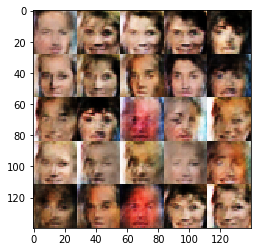

Bacth 4410: Epoch 1/1... Discriminator Loss: 1.2261... Generator Loss: 1.1381
Bacth 4420: Epoch 1/1... Discriminator Loss: 0.9389... Generator Loss: 1.5702
Bacth 4430: Epoch 1/1... Discriminator Loss: 0.7292... Generator Loss: 1.8593
Bacth 4440: Epoch 1/1... Discriminator Loss: 0.8932... Generator Loss: 1.5546
Bacth 4450: Epoch 1/1... Discriminator Loss: 1.1200... Generator Loss: 1.4077
Bacth 4460: Epoch 1/1... Discriminator Loss: 1.0567... Generator Loss: 1.1735
Bacth 4470: Epoch 1/1... Discriminator Loss: 1.2001... Generator Loss: 0.8978
Bacth 4480: Epoch 1/1... Discriminator Loss: 1.3051... Generator Loss: 1.1113
Bacth 4490: Epoch 1/1... Discriminator Loss: 1.4354... Generator Loss: 2.0510
Bacth 4500: Epoch 1/1... Discriminator Loss: 1.3655... Generator Loss: 1.5517


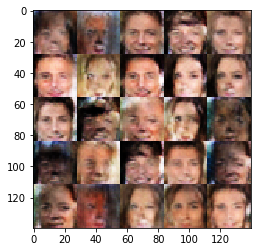

Bacth 4510: Epoch 1/1... Discriminator Loss: 1.2440... Generator Loss: 0.8874
Bacth 4520: Epoch 1/1... Discriminator Loss: 1.1625... Generator Loss: 1.1481
Bacth 4530: Epoch 1/1... Discriminator Loss: 1.3859... Generator Loss: 1.7524
Bacth 4540: Epoch 1/1... Discriminator Loss: 1.5028... Generator Loss: 2.1270
Bacth 4550: Epoch 1/1... Discriminator Loss: 1.1858... Generator Loss: 1.9700
Bacth 4560: Epoch 1/1... Discriminator Loss: 0.9459... Generator Loss: 1.5769
Bacth 4570: Epoch 1/1... Discriminator Loss: 1.1605... Generator Loss: 1.8816
Bacth 4580: Epoch 1/1... Discriminator Loss: 0.9608... Generator Loss: 1.2188
Bacth 4590: Epoch 1/1... Discriminator Loss: 0.8878... Generator Loss: 1.8525
Bacth 4600: Epoch 1/1... Discriminator Loss: 1.5351... Generator Loss: 0.5989


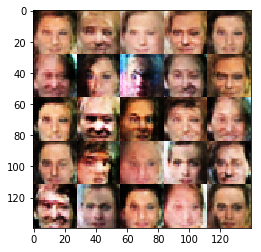

Bacth 4610: Epoch 1/1... Discriminator Loss: 1.1045... Generator Loss: 1.4854
Bacth 4620: Epoch 1/1... Discriminator Loss: 1.1581... Generator Loss: 0.9951
Bacth 4630: Epoch 1/1... Discriminator Loss: 1.0015... Generator Loss: 1.3074
Bacth 4640: Epoch 1/1... Discriminator Loss: 1.0473... Generator Loss: 1.5810
Bacth 4650: Epoch 1/1... Discriminator Loss: 0.9726... Generator Loss: 1.3381
Bacth 4660: Epoch 1/1... Discriminator Loss: 1.1184... Generator Loss: 1.3479
Bacth 4670: Epoch 1/1... Discriminator Loss: 0.9929... Generator Loss: 1.9171
Bacth 4680: Epoch 1/1... Discriminator Loss: 1.0180... Generator Loss: 1.2285
Bacth 4690: Epoch 1/1... Discriminator Loss: 1.0798... Generator Loss: 1.2202
Bacth 4700: Epoch 1/1... Discriminator Loss: 1.0842... Generator Loss: 0.9358


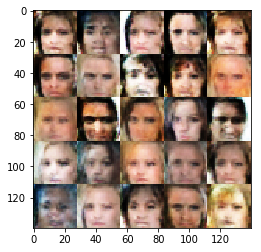

Bacth 4710: Epoch 1/1... Discriminator Loss: 1.5597... Generator Loss: 0.5603
Bacth 4720: Epoch 1/1... Discriminator Loss: 1.5624... Generator Loss: 2.1273
Bacth 4730: Epoch 1/1... Discriminator Loss: 1.1929... Generator Loss: 1.1504
Bacth 4740: Epoch 1/1... Discriminator Loss: 1.3359... Generator Loss: 1.4594
Bacth 4750: Epoch 1/1... Discriminator Loss: 1.3358... Generator Loss: 0.8956
Bacth 4760: Epoch 1/1... Discriminator Loss: 1.0445... Generator Loss: 1.8389
Bacth 4770: Epoch 1/1... Discriminator Loss: 0.8693... Generator Loss: 1.7028
Bacth 4780: Epoch 1/1... Discriminator Loss: 1.0959... Generator Loss: 1.3478
Bacth 4790: Epoch 1/1... Discriminator Loss: 1.0286... Generator Loss: 1.9761
Bacth 4800: Epoch 1/1... Discriminator Loss: 1.0898... Generator Loss: 1.3400


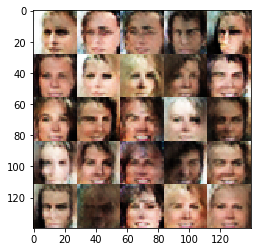

Bacth 4810: Epoch 1/1... Discriminator Loss: 1.1610... Generator Loss: 1.4608
Bacth 4820: Epoch 1/1... Discriminator Loss: 0.9867... Generator Loss: 1.3975
Bacth 4830: Epoch 1/1... Discriminator Loss: 1.5473... Generator Loss: 0.5379
Bacth 4840: Epoch 1/1... Discriminator Loss: 0.9018... Generator Loss: 2.5592
Bacth 4850: Epoch 1/1... Discriminator Loss: 0.9655... Generator Loss: 1.4229
Bacth 4860: Epoch 1/1... Discriminator Loss: 1.2950... Generator Loss: 1.6214
Bacth 4870: Epoch 1/1... Discriminator Loss: 1.1061... Generator Loss: 1.6937
Bacth 4880: Epoch 1/1... Discriminator Loss: 0.9400... Generator Loss: 1.7359
Bacth 4890: Epoch 1/1... Discriminator Loss: 1.1545... Generator Loss: 0.9359
Bacth 4900: Epoch 1/1... Discriminator Loss: 1.3085... Generator Loss: 0.8035


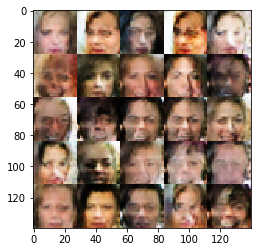

Bacth 4910: Epoch 1/1... Discriminator Loss: 1.0572... Generator Loss: 0.9826
Bacth 4920: Epoch 1/1... Discriminator Loss: 1.1219... Generator Loss: 0.9334
Bacth 4930: Epoch 1/1... Discriminator Loss: 1.3355... Generator Loss: 2.2742
Bacth 4940: Epoch 1/1... Discriminator Loss: 1.3645... Generator Loss: 0.7714
Bacth 4950: Epoch 1/1... Discriminator Loss: 1.0061... Generator Loss: 1.1023
Bacth 4960: Epoch 1/1... Discriminator Loss: 0.8986... Generator Loss: 1.5505
Bacth 4970: Epoch 1/1... Discriminator Loss: 1.1406... Generator Loss: 0.7821
Bacth 4980: Epoch 1/1... Discriminator Loss: 1.5620... Generator Loss: 2.0920
Bacth 4990: Epoch 1/1... Discriminator Loss: 1.3771... Generator Loss: 0.8882
Bacth 5000: Epoch 1/1... Discriminator Loss: 0.9469... Generator Loss: 1.1737


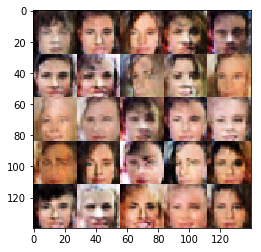

Bacth 5010: Epoch 1/1... Discriminator Loss: 1.1529... Generator Loss: 0.9701
Bacth 5020: Epoch 1/1... Discriminator Loss: 0.7322... Generator Loss: 1.7295
Bacth 5030: Epoch 1/1... Discriminator Loss: 1.0958... Generator Loss: 0.9969
Bacth 5040: Epoch 1/1... Discriminator Loss: 1.3668... Generator Loss: 2.3342
Bacth 5050: Epoch 1/1... Discriminator Loss: 1.0153... Generator Loss: 1.9179
Bacth 5060: Epoch 1/1... Discriminator Loss: 1.3175... Generator Loss: 1.0566
Bacth 5070: Epoch 1/1... Discriminator Loss: 1.1387... Generator Loss: 1.4709
Bacth 5080: Epoch 1/1... Discriminator Loss: 1.3462... Generator Loss: 0.9259
Bacth 5090: Epoch 1/1... Discriminator Loss: 1.0901... Generator Loss: 1.6653
Bacth 5100: Epoch 1/1... Discriminator Loss: 1.0563... Generator Loss: 1.1448


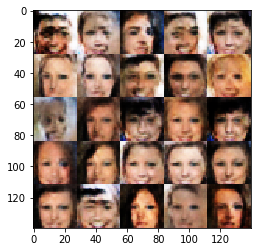

Bacth 5110: Epoch 1/1... Discriminator Loss: 1.2047... Generator Loss: 1.3171
Bacth 5120: Epoch 1/1... Discriminator Loss: 1.0350... Generator Loss: 2.1405
Bacth 5130: Epoch 1/1... Discriminator Loss: 1.2489... Generator Loss: 1.0808
Bacth 5140: Epoch 1/1... Discriminator Loss: 1.1537... Generator Loss: 1.6569
Bacth 5150: Epoch 1/1... Discriminator Loss: 1.1347... Generator Loss: 2.4823
Bacth 5160: Epoch 1/1... Discriminator Loss: 0.8804... Generator Loss: 1.5829
Bacth 5170: Epoch 1/1... Discriminator Loss: 1.1180... Generator Loss: 0.9095
Bacth 5180: Epoch 1/1... Discriminator Loss: 1.0550... Generator Loss: 1.2760
Bacth 5190: Epoch 1/1... Discriminator Loss: 1.1406... Generator Loss: 2.6056
Bacth 5200: Epoch 1/1... Discriminator Loss: 1.0714... Generator Loss: 1.8722


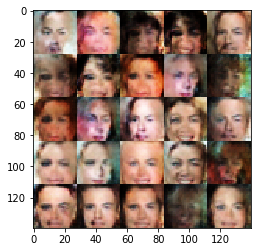

Bacth 5210: Epoch 1/1... Discriminator Loss: 1.2116... Generator Loss: 1.0077
Bacth 5220: Epoch 1/1... Discriminator Loss: 1.4443... Generator Loss: 2.3971
Bacth 5230: Epoch 1/1... Discriminator Loss: 1.1616... Generator Loss: 0.9681
Bacth 5240: Epoch 1/1... Discriminator Loss: 0.8996... Generator Loss: 1.7132
Bacth 5250: Epoch 1/1... Discriminator Loss: 1.0365... Generator Loss: 1.7167
Bacth 5260: Epoch 1/1... Discriminator Loss: 1.0096... Generator Loss: 1.3086
Bacth 5270: Epoch 1/1... Discriminator Loss: 0.8975... Generator Loss: 1.2128
Bacth 5280: Epoch 1/1... Discriminator Loss: 1.2219... Generator Loss: 1.2758
Bacth 5290: Epoch 1/1... Discriminator Loss: 1.0410... Generator Loss: 1.4687
Bacth 5300: Epoch 1/1... Discriminator Loss: 1.0987... Generator Loss: 1.9322


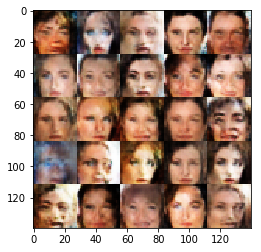

Bacth 5310: Epoch 1/1... Discriminator Loss: 0.8105... Generator Loss: 2.0539
Bacth 5320: Epoch 1/1... Discriminator Loss: 0.9735... Generator Loss: 1.8637
Bacth 5330: Epoch 1/1... Discriminator Loss: 1.1129... Generator Loss: 0.7737
Bacth 5340: Epoch 1/1... Discriminator Loss: 0.9143... Generator Loss: 2.1589
Bacth 5350: Epoch 1/1... Discriminator Loss: 1.0388... Generator Loss: 1.1528
Bacth 5360: Epoch 1/1... Discriminator Loss: 0.9407... Generator Loss: 2.1406
Bacth 5370: Epoch 1/1... Discriminator Loss: 1.0772... Generator Loss: 1.7499
Bacth 5380: Epoch 1/1... Discriminator Loss: 1.3164... Generator Loss: 0.7719
Bacth 5390: Epoch 1/1... Discriminator Loss: 1.1979... Generator Loss: 0.8902
Bacth 5400: Epoch 1/1... Discriminator Loss: 1.0653... Generator Loss: 1.4955


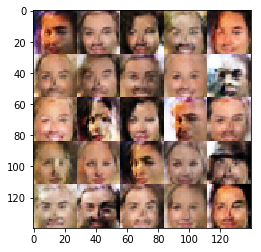

Bacth 5410: Epoch 1/1... Discriminator Loss: 0.9910... Generator Loss: 1.2951
Bacth 5420: Epoch 1/1... Discriminator Loss: 1.1043... Generator Loss: 1.9887
Bacth 5430: Epoch 1/1... Discriminator Loss: 1.0767... Generator Loss: 0.9989
Bacth 5440: Epoch 1/1... Discriminator Loss: 1.0657... Generator Loss: 2.2395
Bacth 5450: Epoch 1/1... Discriminator Loss: 0.8590... Generator Loss: 1.4069
Bacth 5460: Epoch 1/1... Discriminator Loss: 1.1312... Generator Loss: 1.5031
Bacth 5470: Epoch 1/1... Discriminator Loss: 1.0665... Generator Loss: 1.5190
Bacth 5480: Epoch 1/1... Discriminator Loss: 1.1481... Generator Loss: 1.2895
Bacth 5490: Epoch 1/1... Discriminator Loss: 1.4469... Generator Loss: 0.8126
Bacth 5500: Epoch 1/1... Discriminator Loss: 1.2026... Generator Loss: 1.5430


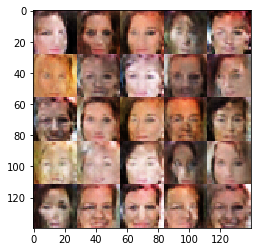

Bacth 5510: Epoch 1/1... Discriminator Loss: 0.9543... Generator Loss: 2.3313
Bacth 5520: Epoch 1/1... Discriminator Loss: 0.9680... Generator Loss: 1.8646
Bacth 5530: Epoch 1/1... Discriminator Loss: 1.1653... Generator Loss: 1.9131
Bacth 5540: Epoch 1/1... Discriminator Loss: 1.0926... Generator Loss: 1.2590
Bacth 5550: Epoch 1/1... Discriminator Loss: 1.1539... Generator Loss: 1.7656
Bacth 5560: Epoch 1/1... Discriminator Loss: 1.3437... Generator Loss: 2.3458
Bacth 5570: Epoch 1/1... Discriminator Loss: 0.9704... Generator Loss: 1.4913
Bacth 5580: Epoch 1/1... Discriminator Loss: 0.9835... Generator Loss: 1.6368
Bacth 5590: Epoch 1/1... Discriminator Loss: 1.0719... Generator Loss: 1.5216
Bacth 5600: Epoch 1/1... Discriminator Loss: 1.2458... Generator Loss: 0.8740


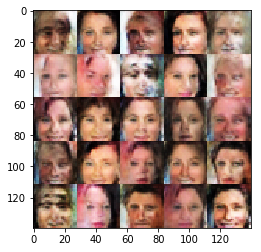

Bacth 5610: Epoch 1/1... Discriminator Loss: 0.8667... Generator Loss: 1.4906
Bacth 5620: Epoch 1/1... Discriminator Loss: 1.1878... Generator Loss: 2.6241
Bacth 5630: Epoch 1/1... Discriminator Loss: 0.9316... Generator Loss: 1.3668
Bacth 5640: Epoch 1/1... Discriminator Loss: 1.1172... Generator Loss: 1.4141
Bacth 5650: Epoch 1/1... Discriminator Loss: 1.0853... Generator Loss: 0.9818
Bacth 5660: Epoch 1/1... Discriminator Loss: 1.1512... Generator Loss: 1.5507
Bacth 5670: Epoch 1/1... Discriminator Loss: 1.1330... Generator Loss: 1.0217
Bacth 5680: Epoch 1/1... Discriminator Loss: 1.1015... Generator Loss: 1.3876
Bacth 5690: Epoch 1/1... Discriminator Loss: 0.9159... Generator Loss: 1.1248
Bacth 5700: Epoch 1/1... Discriminator Loss: 0.9478... Generator Loss: 1.6011


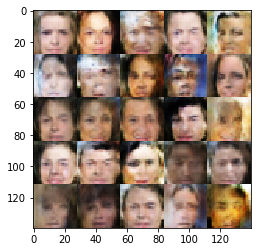

Bacth 5710: Epoch 1/1... Discriminator Loss: 1.2037... Generator Loss: 1.4335
Bacth 5720: Epoch 1/1... Discriminator Loss: 1.2747... Generator Loss: 1.5710
Bacth 5730: Epoch 1/1... Discriminator Loss: 1.3906... Generator Loss: 1.4991
Bacth 5740: Epoch 1/1... Discriminator Loss: 1.1388... Generator Loss: 1.6949
Bacth 5750: Epoch 1/1... Discriminator Loss: 0.9574... Generator Loss: 1.6611
Bacth 5760: Epoch 1/1... Discriminator Loss: 1.1385... Generator Loss: 2.8780
Bacth 5770: Epoch 1/1... Discriminator Loss: 0.9756... Generator Loss: 1.8435
Bacth 5780: Epoch 1/1... Discriminator Loss: 1.0800... Generator Loss: 1.5895
Bacth 5790: Epoch 1/1... Discriminator Loss: 1.2629... Generator Loss: 1.1087
Bacth 5800: Epoch 1/1... Discriminator Loss: 1.3939... Generator Loss: 2.6672


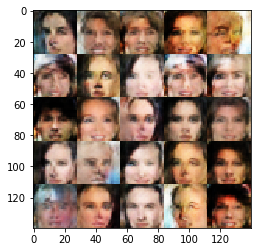

Bacth 5810: Epoch 1/1... Discriminator Loss: 1.1904... Generator Loss: 1.5432
Bacth 5820: Epoch 1/1... Discriminator Loss: 1.1814... Generator Loss: 2.0004
Bacth 5830: Epoch 1/1... Discriminator Loss: 1.1677... Generator Loss: 2.0297
Bacth 5840: Epoch 1/1... Discriminator Loss: 1.2410... Generator Loss: 1.5330
Bacth 5850: Epoch 1/1... Discriminator Loss: 1.4720... Generator Loss: 1.1716
Bacth 5860: Epoch 1/1... Discriminator Loss: 1.3282... Generator Loss: 1.2037
Bacth 5870: Epoch 1/1... Discriminator Loss: 1.3960... Generator Loss: 1.5005
Bacth 5880: Epoch 1/1... Discriminator Loss: 1.3375... Generator Loss: 1.8130
Bacth 5890: Epoch 1/1... Discriminator Loss: 1.0869... Generator Loss: 1.2666
Bacth 5900: Epoch 1/1... Discriminator Loss: 1.2875... Generator Loss: 1.7157


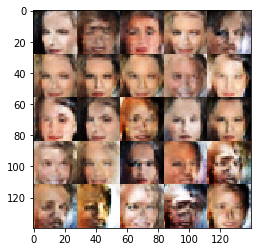

Bacth 5910: Epoch 1/1... Discriminator Loss: 1.2569... Generator Loss: 1.2570
Bacth 5920: Epoch 1/1... Discriminator Loss: 1.3355... Generator Loss: 1.1676
Bacth 5930: Epoch 1/1... Discriminator Loss: 1.2400... Generator Loss: 1.4534
Bacth 5940: Epoch 1/1... Discriminator Loss: 1.2233... Generator Loss: 1.0977
Bacth 5950: Epoch 1/1... Discriminator Loss: 1.1367... Generator Loss: 1.4571
Bacth 5960: Epoch 1/1... Discriminator Loss: 1.3736... Generator Loss: 0.8095
Bacth 5970: Epoch 1/1... Discriminator Loss: 1.2431... Generator Loss: 1.7008
Bacth 5980: Epoch 1/1... Discriminator Loss: 0.9134... Generator Loss: 2.5313
Bacth 5990: Epoch 1/1... Discriminator Loss: 0.9712... Generator Loss: 1.2257
Bacth 6000: Epoch 1/1... Discriminator Loss: 1.0353... Generator Loss: 1.4546


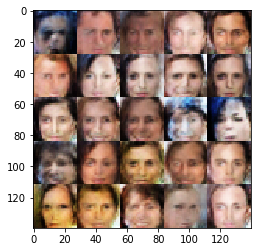

Bacth 6010: Epoch 1/1... Discriminator Loss: 1.2476... Generator Loss: 1.4792
Bacth 6020: Epoch 1/1... Discriminator Loss: 1.2111... Generator Loss: 1.0677
Bacth 6030: Epoch 1/1... Discriminator Loss: 1.4022... Generator Loss: 1.8087
Bacth 6040: Epoch 1/1... Discriminator Loss: 0.9922... Generator Loss: 2.1161
Bacth 6050: Epoch 1/1... Discriminator Loss: 0.8694... Generator Loss: 1.6046
Bacth 6060: Epoch 1/1... Discriminator Loss: 1.1244... Generator Loss: 1.6042
Bacth 6070: Epoch 1/1... Discriminator Loss: 1.2566... Generator Loss: 1.6963
Bacth 6080: Epoch 1/1... Discriminator Loss: 1.0680... Generator Loss: 1.7287
Bacth 6090: Epoch 1/1... Discriminator Loss: 1.7867... Generator Loss: 0.4200
Bacth 6100: Epoch 1/1... Discriminator Loss: 1.0244... Generator Loss: 1.7385


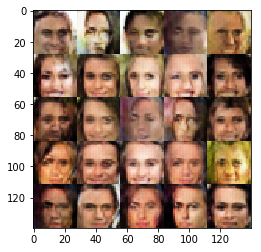

Bacth 6110: Epoch 1/1... Discriminator Loss: 1.0344... Generator Loss: 1.1797
Bacth 6120: Epoch 1/1... Discriminator Loss: 1.3195... Generator Loss: 0.6997
Bacth 6130: Epoch 1/1... Discriminator Loss: 0.8498... Generator Loss: 1.1696
Bacth 6140: Epoch 1/1... Discriminator Loss: 0.8978... Generator Loss: 1.3865
Bacth 6150: Epoch 1/1... Discriminator Loss: 0.8766... Generator Loss: 1.5308
Bacth 6160: Epoch 1/1... Discriminator Loss: 1.0809... Generator Loss: 1.6185
Bacth 6170: Epoch 1/1... Discriminator Loss: 1.0797... Generator Loss: 1.2326
Bacth 6180: Epoch 1/1... Discriminator Loss: 1.1484... Generator Loss: 0.8945
Bacth 6190: Epoch 1/1... Discriminator Loss: 0.9345... Generator Loss: 1.0864
Bacth 6200: Epoch 1/1... Discriminator Loss: 0.9262... Generator Loss: 1.8178


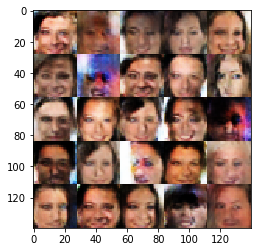

Bacth 6210: Epoch 1/1... Discriminator Loss: 1.1708... Generator Loss: 0.8470
Bacth 6220: Epoch 1/1... Discriminator Loss: 1.0318... Generator Loss: 1.4211
Bacth 6230: Epoch 1/1... Discriminator Loss: 1.4746... Generator Loss: 1.6496
Bacth 6240: Epoch 1/1... Discriminator Loss: 1.0235... Generator Loss: 1.3631
Bacth 6250: Epoch 1/1... Discriminator Loss: 0.8437... Generator Loss: 1.2024
Bacth 6260: Epoch 1/1... Discriminator Loss: 1.1669... Generator Loss: 1.0817
Bacth 6270: Epoch 1/1... Discriminator Loss: 1.4461... Generator Loss: 0.6427
Bacth 6280: Epoch 1/1... Discriminator Loss: 1.3081... Generator Loss: 1.2637
Bacth 6290: Epoch 1/1... Discriminator Loss: 1.1566... Generator Loss: 0.9487
Bacth 6300: Epoch 1/1... Discriminator Loss: 1.2249... Generator Loss: 2.4041


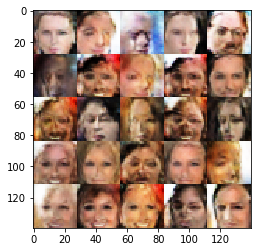

Bacth 6310: Epoch 1/1... Discriminator Loss: 0.9107... Generator Loss: 1.3211
Bacth 6320: Epoch 1/1... Discriminator Loss: 0.7704... Generator Loss: 2.1053
Bacth 6330: Epoch 1/1... Discriminator Loss: 0.9863... Generator Loss: 1.7498


In [13]:
batch_size = 32
z_dim = 100
learning_rate = 0.0003
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.